# Predictive Maintenance using Random Forests

## Problem Statement

### Background

> A company has a fleet of devices transmitting daily telemetry readings. They would like to create a predictive
maintenance solution to proactively identify when maintenance should be performed. This approach promises cost
savings over routine or time-based preventive maintenance, because tasks are performed only when warranted.

### Goal

>You are tasked with building a predictive model using machine learning to predict the probability of a device failure.
When building this model, be sure to minimize false positives and false negatives. The column you are trying to predict
is called failure with binary value 0 for non-failure and 1 for failure.

## Tech Stack

* [Kedro](https://github.com/quantumblacklabs/kedro) - workflow development tool that helps you build data pipelines that are robust, scalable, deployable, reproducible and versioned.
* [PySpark](https://github.com/apache/spark/tree/master/python) - Python API to Spark (a fast and general cluster computing system for Big Data).
* [spark-sklearn](https://github.com/databricks/spark-sklearn) - tools to integrate the Spark computing framework with the popular scikit-learn machine learning library.
* pandas
* NumPy
* matplotlib
* seaborn

In [8]:
# Kedro imports.
from kedro.io import DataCatalog
from kedro.contrib.io.pyspark import SparkDataSet
from kedro.pipeline import Pipeline as KedroPipeline, node
from kedro.config import ConfigLoader
from kedro.runner import SequentialRunner

# PySpark imports.
from pyspark.sql import SparkSession
spark = SparkSession.builder \
    .appName('predictive-maintenance') \
    .master('local[*]') \
    .getOrCreate()
from pyspark.ml.feature import SQLTransformer
from pyspark.ml import Pipeline as SparkPipeline
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.feature import StandardScaler

# Import Pandas and NumPy.
import pandas as pd
pd.options.display.max_columns = 500
import numpy as np

# Import matplotlib and seaborn.
import matplotlib.pyplot as plt
import seaborn as sns

## Read and Clean Data

Load telemetry data into Spark DataFrame using Kedro.

In [2]:
telemetry_sds = SparkDataSet(
    filepath='../data/01_raw/predictive_maintenance.csv',
    file_format='csv',
    load_args={'sep': ',', 'header': True},
    save_args={'sep': ',', 'header': True}
)
catalog = DataCatalog({'telemetry': telemetry_sds})
telemetry_sdf = catalog.load('telemetry')

Create Kedro node (just a function) to clean telemetry data.

In [3]:
def clean_telemetry(telemetry):
    """Clean telemetry data.
    
    Args:
        telemetry: Spark DataFrame containing telemetry data.
    Returns:
        Cleaned telemetry Spark DataFrame.
        
    """
    telemetry.createOrReplaceTempView('telemetry')
    telemetry = spark.sql(
    '''
    SELECT
        CAST(date AS DATE) AS date,
        id,
        CAST(failure AS INTEGER) AS label,
        CAST(metric1 AS DOUBLE) AS metric1,
        CAST(metric2 AS DOUBLE) AS metric2,
        CAST(metric3 AS DOUBLE) AS metric3,
        CAST(metric4 AS DOUBLE) AS metric4,
        CAST(metric5 AS DOUBLE) AS metric5,
        CAST(metric6 AS DOUBLE) AS metric6,
        CAST(metric7 AS DOUBLE) AS metric7,
        CAST(metric8 AS DOUBLE) AS metric8,
        CAST(metric9 AS DOUBLE) AS metric9
    FROM telemetry
    ''')
    spark.catalog.dropTempView('telemetry')
    return telemetry

clean_telemetry_sdf = clean_telemetry(telemetry_sdf)
clean_telemetry_sdf.printSchema()

root
 |-- date: date (nullable = true)
 |-- id: string (nullable = true)
 |-- label: integer (nullable = true)
 |-- metric1: double (nullable = true)
 |-- metric2: double (nullable = true)
 |-- metric3: double (nullable = true)
 |-- metric4: double (nullable = true)
 |-- metric5: double (nullable = true)
 |-- metric6: double (nullable = true)
 |-- metric7: double (nullable = true)
 |-- metric8: double (nullable = true)
 |-- metric9: double (nullable = true)



## Create Data Pipeline

That's it! We've created an (admittedly simple) data pipeline with Kedro. We'll create a machine learning pipeline with PySpark in a bit, but first let's explore our data to figure out what features to build! 

In [4]:
kedro_pipeline = KedroPipeline([
    node(func=clean_telemetry, inputs='telemetry', outputs='clean_telemetry')
])
clean_telemetry_sdf = SequentialRunner().run(kedro_pipeline, catalog)['clean_telemetry']
clean_telemetry_sdf.select('*').limit(5).toPandas()

,date,id,label,metric1,metric2,metric3,metric4,metric5,metric6,metric7,metric8,metric9
0,2015-01-01,S1F01085,0,215630672.0,56.0,0.0,52.0,6.0,407438.0,0.0,0.0,7.0
1,2015-01-01,S1F0166B,0,61370680.0,0.0,3.0,0.0,6.0,403174.0,0.0,0.0,0.0
2,2015-01-01,S1F01E6Y,0,173295968.0,0.0,0.0,0.0,12.0,237394.0,0.0,0.0,0.0
3,2015-01-01,S1F01JE0,0,79694024.0,0.0,0.0,0.0,6.0,410186.0,0.0,0.0,0.0
4,2015-01-01,S1F01R2B,0,135970480.0,0.0,0.0,0.0,15.0,313173.0,0.0,0.0,3.0


## Explore Data

In [5]:
clean_telemetry_sdf.createOrReplaceTempView('clean_telemetry')

Drift, 5-day moving average, 5-day moving average z-score, standard deviation, age

In [6]:
failures_df = spark.sql(
'''
SELECT *
FROM clean_telemetry
WHERE id IN (
    SELECT id
    FROM clean_telemetry
    WHERE label = 1
)
ORDER BY id, date
''').toPandas()
failures_df['date'] = pd.to_datetime(failures_df['date'])

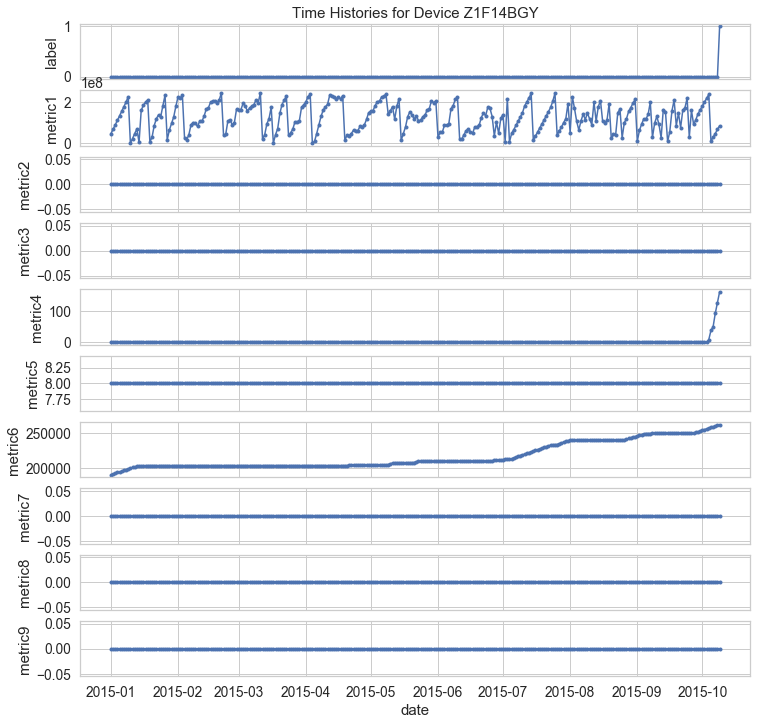

In [32]:
failure_id = np.random.choice(failures_df['id'].unique())
failure_df = failures_df.loc[failures_df['id']==failure_id]

sns.set(font_scale=1.25, style='whitegrid')
fig, axs = plt.subplots(nrows=10, ncols=1, sharex=True, figsize=(12,12))
axs[0].set_title('Time Histories for Device ' + failure_id)
axs[0].plot('date','label', data=failure_df, linestyle='-', marker='o', markersize=3); axs[0].set_ylabel('label')
axs[1].plot('date','metric1', data=failure_df, linestyle='-', marker='o', markersize=3); axs[1].set_ylabel('metric1')
axs[2].plot('date','metric2', data=failure_df, linestyle='-', marker='o', markersize=3); axs[2].set_ylabel('metric2')
axs[3].plot('date','metric3', data=failure_df, linestyle='-', marker='o', markersize=3); axs[3].set_ylabel('metric3')
axs[4].plot('date','metric4', data=failure_df, linestyle='-', marker='o', markersize=3); axs[4].set_ylabel('metric4')
axs[5].plot('date','metric5', data=failure_df, linestyle='-', marker='o', markersize=3); axs[5].set_ylabel('metric5')
axs[6].plot('date','metric6', data=failure_df, linestyle='-', marker='o', markersize=3); axs[6].set_ylabel('metric6')
axs[7].plot('date','metric7', data=failure_df, linestyle='-', marker='o', markersize=3); axs[7].set_ylabel('metric7')
axs[8].plot('date','metric8', data=failure_df, linestyle='-', marker='o', markersize=3); axs[8].set_ylabel('metric8')
axs[9].plot('date','metric9', data=failure_df, linestyle='-', marker='o', markersize=3); axs[9].set_ylabel('metric9'); axs[9].set_xlabel('date');

## Engineer Features

Drift, 5-day moving average, 5-day moving average z-score, standard deviation, age

In [70]:
summary_sql = \
'''
SELECT
    *,
    -- Calculate device level label.
    MAX(date_level_label) OVER (PARTITION BY id) AS label,
    -- Calculate device level age in days.
    CAST(DATEDIFF(max_date, min_date) + 1 AS DOUBLE) AS age,
    -- Calculate device level 5-day moving average z-scores.
    COALESCE(AVG((metric1 - mean_metric1) / sd_metric1) OVER (PARTITION BY id ORDER BY date ASC ROWS BETWEEN 4 PRECEDING AND CURRENT ROW),0) AS zs_metric1,
    COALESCE(AVG((metric2 - mean_metric2) / sd_metric2) OVER (PARTITION BY id ORDER BY date ASC ROWS BETWEEN 4 PRECEDING AND CURRENT ROW),0) AS zs_metric2,
    COALESCE(AVG((metric3 - mean_metric3) / sd_metric3) OVER (PARTITION BY id ORDER BY date ASC ROWS BETWEEN 4 PRECEDING AND CURRENT ROW),0) AS zs_metric3,
    COALESCE(AVG((metric4 - mean_metric4) / sd_metric4) OVER (PARTITION BY id ORDER BY date ASC ROWS BETWEEN 4 PRECEDING AND CURRENT ROW),0) AS zs_metric4,
    COALESCE(AVG((metric5 - mean_metric5) / sd_metric5) OVER (PARTITION BY id ORDER BY date ASC ROWS BETWEEN 4 PRECEDING AND CURRENT ROW),0) AS zs_metric5,
    COALESCE(AVG((metric6 - mean_metric6) / sd_metric6) OVER (PARTITION BY id ORDER BY date ASC ROWS BETWEEN 4 PRECEDING AND CURRENT ROW),0) AS zs_metric6,
    COALESCE(AVG((metric7 - mean_metric7) / sd_metric7) OVER (PARTITION BY id ORDER BY date ASC ROWS BETWEEN 4 PRECEDING AND CURRENT ROW),0) AS zs_metric7,
    COALESCE(AVG((metric8 - mean_metric8) / sd_metric8) OVER (PARTITION BY id ORDER BY date ASC ROWS BETWEEN 4 PRECEDING AND CURRENT ROW),0) AS zs_metric8,
    COALESCE(AVG((metric9 - mean_metric9) / sd_metric9) OVER (PARTITION BY id ORDER BY date ASC ROWS BETWEEN 4 PRECEDING AND CURRENT ROW),0) AS zs_metric9,
    -- Calculate device level first to last value drifts.
    (last_metric1 - first_metric1) AS drift_metric1,
    (last_metric2 - first_metric2) AS drift_metric2,
    (last_metric3 - first_metric3) AS drift_metric3,
    (last_metric4 - first_metric4) AS drift_metric4,
    (last_metric5 - first_metric5) AS drift_metric5,
    (last_metric6 - first_metric6) AS drift_metric6,
    (last_metric7 - first_metric7) AS drift_metric7,
    (last_metric8 - first_metric8) AS drift_metric8,
    (last_metric9 - first_metric9) AS drift_metric9
FROM (
    SELECT
        id,
        date,
        label AS date_level_label,
        metric1,
        metric2,
        metric3,
        metric4,
        metric5,
        metric6,
        metric7,
        metric8,
        metric9,
        -- Calculate device level averages.
        AVG(metric1) OVER (PARTITION BY id) AS mean_metric1,
        AVG(metric2) OVER (PARTITION BY id) AS mean_metric2,
        AVG(metric3) OVER (PARTITION BY id) AS mean_metric3,
        AVG(metric4) OVER (PARTITION BY id) AS mean_metric4,
        AVG(metric5) OVER (PARTITION BY id) AS mean_metric5,
        AVG(metric6) OVER (PARTITION BY id) AS mean_metric6,
        AVG(metric7) OVER (PARTITION BY id) AS mean_metric7,
        AVG(metric8) OVER (PARTITION BY id) AS mean_metric8,
        AVG(metric9) OVER (PARTITION BY id) AS mean_metric9,
        -- Calculate device level 5-day moving averages.
        AVG(metric1) OVER (PARTITION BY id ORDER BY date ASC ROWS BETWEEN 4 PRECEDING AND CURRENT ROW) AS ma_metric1,
        AVG(metric2) OVER (PARTITION BY id ORDER BY date ASC ROWS BETWEEN 4 PRECEDING AND CURRENT ROW) AS ma_metric2,
        AVG(metric3) OVER (PARTITION BY id ORDER BY date ASC ROWS BETWEEN 4 PRECEDING AND CURRENT ROW) AS ma_metric3,
        AVG(metric4) OVER (PARTITION BY id ORDER BY date ASC ROWS BETWEEN 4 PRECEDING AND CURRENT ROW) AS ma_metric4,
        AVG(metric5) OVER (PARTITION BY id ORDER BY date ASC ROWS BETWEEN 4 PRECEDING AND CURRENT ROW) AS ma_metric5,
        AVG(metric6) OVER (PARTITION BY id ORDER BY date ASC ROWS BETWEEN 4 PRECEDING AND CURRENT ROW) AS ma_metric6,
        AVG(metric7) OVER (PARTITION BY id ORDER BY date ASC ROWS BETWEEN 4 PRECEDING AND CURRENT ROW) AS ma_metric7,
        AVG(metric8) OVER (PARTITION BY id ORDER BY date ASC ROWS BETWEEN 4 PRECEDING AND CURRENT ROW) AS ma_metric8,
        AVG(metric9) OVER (PARTITION BY id ORDER BY date ASC ROWS BETWEEN 4 PRECEDING AND CURRENT ROW) AS ma_metric9,
        -- Calculate device level standard deviations.
        STDDEV_SAMP(metric1) OVER (PARTITION BY id) AS sd_metric1,
        STDDEV_SAMP(metric2) OVER (PARTITION BY id) AS sd_metric2,
        STDDEV_SAMP(metric3) OVER (PARTITION BY id) AS sd_metric3,
        STDDEV_SAMP(metric4) OVER (PARTITION BY id) AS sd_metric4,
        STDDEV_SAMP(metric5) OVER (PARTITION BY id) AS sd_metric5,
        STDDEV_SAMP(metric6) OVER (PARTITION BY id) AS sd_metric6,
        STDDEV_SAMP(metric7) OVER (PARTITION BY id) AS sd_metric7,
        STDDEV_SAMP(metric8) OVER (PARTITION BY id) AS sd_metric8,
        STDDEV_SAMP(metric9) OVER (PARTITION BY id) AS sd_metric9,
        -- Calculate device level first values.
        FIRST_VALUE(metric1) OVER (PARTITION BY id ORDER BY date ASC) AS first_metric1,
        FIRST_VALUE(metric2) OVER (PARTITION BY id ORDER BY date ASC) AS first_metric2,
        FIRST_VALUE(metric3) OVER (PARTITION BY id ORDER BY date ASC) AS first_metric3,
        FIRST_VALUE(metric4) OVER (PARTITION BY id ORDER BY date ASC) AS first_metric4,
        FIRST_VALUE(metric5) OVER (PARTITION BY id ORDER BY date ASC) AS first_metric5,
        FIRST_VALUE(metric6) OVER (PARTITION BY id ORDER BY date ASC) AS first_metric6,
        FIRST_VALUE(metric7) OVER (PARTITION BY id ORDER BY date ASC) AS first_metric7,
        FIRST_VALUE(metric8) OVER (PARTITION BY id ORDER BY date ASC) AS first_metric8,
        FIRST_VALUE(metric9) OVER (PARTITION BY id ORDER BY date ASC) AS first_metric9,
        -- Calculate device level last values.
        LAST_VALUE(metric1) OVER (PARTITION BY id ORDER BY date ASC) AS last_metric1,
        LAST_VALUE(metric2) OVER (PARTITION BY id ORDER BY date ASC) AS last_metric2,
        LAST_VALUE(metric3) OVER (PARTITION BY id ORDER BY date ASC) AS last_metric3,
        LAST_VALUE(metric4) OVER (PARTITION BY id ORDER BY date ASC) AS last_metric4,
        LAST_VALUE(metric5) OVER (PARTITION BY id ORDER BY date ASC) AS last_metric5,
        LAST_VALUE(metric6) OVER (PARTITION BY id ORDER BY date ASC) AS last_metric6,
        LAST_VALUE(metric7) OVER (PARTITION BY id ORDER BY date ASC) AS last_metric7,
        LAST_VALUE(metric8) OVER (PARTITION BY id ORDER BY date ASC) AS last_metric8,
        LAST_VALUE(metric9) OVER (PARTITION BY id ORDER BY date ASC) AS last_metric9,
        -- Calculate device level minimum date.
        MIN(date) OVER (PARTITION BY id) AS min_date,
        -- Calculate device level maximum date.
        MAX(date) OVER (PARTITION BY id) AS max_date,
        -- Count device level number of readings.
        CAST(COUNT(*) OVER (PARTITION BY id) AS DOUBLE) AS readings
    FROM clean_telemetry
)
WHERE date = max_date
'''

summary_transformer = SQLTransformer(statement=summary_sql.replace('clean_telemetry','__THIS__'))
summary_sdf = summary_transformer.transform(clean_telemetry_sdf)
summary_sdf.select('*').limit(5).toPandas()

,id,date,date_level_label,metric1,metric2,metric3,metric4,metric5,metric6,metric7,metric8,metric9,mean_metric1,mean_metric2,mean_metric3,mean_metric4,mean_metric5,mean_metric6,mean_metric7,mean_metric8,mean_metric9,ma_metric1,ma_metric2,ma_metric3,ma_metric4,ma_metric5,ma_metric6,ma_metric7,ma_metric8,ma_metric9,sd_metric1,sd_metric2,sd_metric3,sd_metric4,sd_metric5,sd_metric6,sd_metric7,sd_metric8,sd_metric9,first_metric1,first_metric2,first_metric3,first_metric4,first_metric5,first_metric6,first_metric7,first_metric8,first_metric9,last_metric1,last_metric2,last_metric3,last_metric4,last_metric5,last_metric6,last_metric7,last_metric8,last_metric9,min_date,max_date,readings,label,age,zs_metric1,zs_metric2,zs_metric3,zs_metric4,zs_metric5,zs_metric6,zs_metric7,zs_metric8,zs_metric9,drift_metric1,drift_metric2,drift_metric3,drift_metric4,drift_metric5,drift_metric6,drift_metric7,drift_metric8,drift_metric9
0,S1F0S02A,2015-01-13,0,143993216.0,0.0,0.0,0.0,7.0,256247.0,0.0,0.0,0.0,1.426367e+08,0.000000,0.0,0.000000,7.000000,248891.000000,0.0,0.0,0.0,149435147.2,0.0,0.0,0.0,7.0,253531.2,0.0,0.0,0.0,4.758146e+07,0.000000,0.0,0.000000,0.000000,4266.077629,0.0,0.0,0.0,49170880.0,0.0,0.0,0.0,7.0,244565.0,0.0,0.0,0.0,143993216.0,0.0,0.0,0.0,7.0,256247.0,0.0,0.0,0.0,2015-01-01,2015-01-13,13.0,0,13.0,0.028509,0.000000,0.0,0.000000,0.000000,1.724301,0.0,0.0,0.0,94822336.0,0.0,0.0,0.0,0.0,11682.0,0.0,0.0,0.0
1,S1F1327G,2015-01-05,0,191647672.0,0.0,0.0,0.0,11.0,287781.0,0.0,0.0,0.0,1.505763e+08,0.000000,0.0,0.000000,11.000000,285120.600000,0.0,0.0,0.0,150576339.2,0.0,0.0,0.0,11.0,285120.6,0.0,0.0,0.0,3.229878e+07,0.000000,0.0,0.000000,0.000000,2110.051492,0.0,0.0,0.0,109711784.0,0.0,0.0,0.0,11.0,282440.0,0.0,0.0,0.0,191647672.0,0.0,0.0,0.0,11.0,287781.0,0.0,0.0,0.0,2015-01-01,2015-01-05,5.0,0,5.0,1.271606,0.000000,0.0,0.000000,0.000000,1.260822,0.0,0.0,0.0,81935888.0,0.0,0.0,0.0,0.0,5341.0,0.0,0.0,0.0
2,W1F0PAXH,2015-07-11,1,198736232.0,0.0,0.0,16.0,16.0,336698.0,0.0,0.0,0.0,1.185736e+08,0.000000,0.0,0.260417,14.666667,325862.458333,0.0,0.0,0.0,175158352.0,0.0,0.0,10.0,16.0,336443.8,0.0,0.0,0.0,7.317675e+07,0.000000,0.0,1.863088,0.945274,8146.925139,0.0,0.0,0.0,41481448.0,0.0,0.0,0.0,14.0,302283.0,0.0,0.0,0.0,198736232.0,0.0,0.0,16.0,16.0,336698.0,0.0,0.0,0.0,2015-01-01,2015-07-11,192.0,1,192.0,1.095465,0.000000,0.0,8.448118,1.410526,1.330016,0.0,0.0,0.0,157254784.0,0.0,0.0,16.0,2.0,34415.0,0.0,0.0,0.0
3,W1F11ZG9,2015-08-17,0,133230384.0,648.0,9.0,533.0,3.0,344660.0,0.0,0.0,1.0,1.306916e+08,59.004367,9.0,247.004367,2.908297,339937.812227,0.0,0.0,1.0,198222392.0,443.2,9.0,496.2,3.0,344574.2,0.0,0.0,1.0,7.377543e+07,141.553985,0.0,109.316878,0.289239,4153.084660,0.0,0.0,0.0,193036136.0,0.0,9.0,46.0,2.0,321220.0,0.0,0.0,1.0,133230384.0,648.0,9.0,533.0,3.0,344660.0,0.0,0.0,1.0,2015-01-01,2015-08-17,229.0,0,229.0,0.034412,4.160926,0.0,2.616207,0.317050,1.137031,0.0,0.0,0.0,-59805752.0,648.0,0.0,487.0,1.0,23440.0,0.0,0.0,0.0
4,W1F17RLV,2015-08-20,0,166352776.0,0.0,0.0,0.0,9.0,247046.0,0.0,0.0,0.0,1.155772e+08,0.000000,0.0,0.000000,9.000000,229881.568966,0.0,0.0,0.0,102779809.6,0.0,0.0,0.0,9.0,247044.8,0.0,0.0,0.0,6.742485e+07,0.000000,0.0,0.000000,0.000000,10993.725960,0.0,0.0,0.0,19301992.0,0.0,0.0,0.0,9.0,200359.0,0.0,0.0,0.0,166352776.0,0.0,0.0,0.0,9.0,247046.0,0.0,0.0,0.0,2015-01-01,2015-08-20,232.0,0,232.0,0.753069,0.000000,0.0,0.000000,0.000000,1.561293,0.0,0.0,0.0,147050784.0,0.0,0.0,0.0,0.0,46687.0,0.0,0.0,0.0


In [ ]:
spark.sql(
'''
SELECT
    id,
    -- Label indicating device failure.
    MAX(label) AS label,
    -- Min and max date for each device.
    MIN(date) AS min_date,
    MAX(date) AS max_date,
    -- Age of device in days.
    CAST(DATEDIFF(MAX(date), MIN(date)) + 1 AS DOUBLE) AS age,
    -- Number of telemetry readings.
    CAST(COUNT(*) AS DOUBLE) AS readings,
    -- Mean values for each device.
    AVG(metric1) AS mean_metric1,
    AVG(metric2) AS mean_metric2,
    AVG(metric3) AS mean_metric3,
    AVG(metric4) AS mean_metric4,
    AVG(metric5) AS mean_metric5,
    AVG(metric6) AS mean_metric6,
    AVG(metric7) AS mean_metric7,
    AVG(metric8) AS mean_metric8,
    AVG(metric9) AS mean_metric9,
    -- Standard deviation values for each device.
    STDDEV_SAMP(metric1) AS sd_metric1,
    STDDEV_SAMP(metric2) AS sd_metric2,
    STDDEV_SAMP(metric3) AS sd_metric3,
    STDDEV_SAMP(metric4) AS sd_metric4,
    STDDEV_SAMP(metric5) AS sd_metric5,
    STDDEV_SAMP(metric6) AS sd_metric6,
    STDDEV_SAMP(metric7) AS sd_metric7,
    STDDEV_SAMP(metric8) AS sd_metric8,
    STDDEV_SAMP(metric9) AS sd_metric9
FROM clean_telemetry
GROUP BY id
LIMIT 5
''').toPandas()

In [17]:
summary_sql = \
'''
SELECT
    summary.*,
    -- Drift or difference between first and last values for each device.
    (t2.metric1 - t1.metric1) AS drift_metric1,
    (t2.metric2 - t1.metric2) AS drift_metric2,
    (t2.metric3 - t1.metric3) AS drift_metric3,
    (t2.metric4 - t1.metric4) AS drift_metric4,
    (t2.metric5 - t1.metric5) AS drift_metric5,
    (t2.metric6 - t1.metric6) AS drift_metric6,
    (t2.metric7 - t1.metric7) AS drift_metric7,
    (t2.metric8 - t1.metric8) AS drift_metric8,
    (t2.metric9 - t1.metric9) AS drift_metric9,
    -- Last reading for each device.
    t2.metric1 AS last_metric1,
    t2.metric2 AS last_metric2,
    t2.metric3 AS last_metric3,
    t2.metric4 AS last_metric4,
    t2.metric5 AS last_metric5,
    t2.metric6 AS last_metric6,
    t2.metric7 AS last_metric7,
    t2.metric8 AS last_metric8,
    t2.metric9 AS last_metric9
FROM (
    SELECT
        id,
        -- Label indicating device failure.
        MAX(label) AS label,
        -- Min and max date for each device.
        MIN(date) AS min_date,
        MAX(date) AS max_date,
        -- Age of device in days.
        CAST(DATEDIFF(MAX(date), MIN(date)) + 1 AS DOUBLE) AS age,
        -- Number of telemetry readings.
        CAST(COUNT(*) AS DOUBLE) AS readings,
        -- Mean values for each device.
        AVG(metric1) AS mean_metric1,
        AVG(metric2) AS mean_metric2,
        AVG(metric3) AS mean_metric3,
        AVG(metric4) AS mean_metric4,
        AVG(metric5) AS mean_metric5,
        AVG(metric6) AS mean_metric6,
        AVG(metric7) AS mean_metric7,
        AVG(metric8) AS mean_metric8,
        AVG(metric9) AS mean_metric9,
        -- Standard deviation values for each device.
        STDDEV_SAMP(metric1) AS sd_metric1,
        STDDEV_SAMP(metric2) AS sd_metric2,
        STDDEV_SAMP(metric3) AS sd_metric3,
        STDDEV_SAMP(metric4) AS sd_metric4,
        STDDEV_SAMP(metric5) AS sd_metric5,
        STDDEV_SAMP(metric6) AS sd_metric6,
        STDDEV_SAMP(metric7) AS sd_metric7,
        STDDEV_SAMP(metric8) AS sd_metric8,
        STDDEV_SAMP(metric9) AS sd_metric9
    FROM telemetry
    GROUP BY id
) AS summary
LEFT JOIN telemetry AS t1 ON summary.id = t1.id AND summary.min_date = t1.date
LEFT JOIN telemetry AS t2 ON summary.id = t2.id AND summary.max_date = t2.date
WHERE summary.sd_metric1 != 'NaN'
AND summary.sd_metric2 != 'NaN'
AND summary.sd_metric3 != 'NaN'
AND summary.sd_metric4 != 'NaN'
AND summary.sd_metric5 != 'NaN'
AND summary.sd_metric6 != 'NaN'
AND summary.sd_metric7 != 'NaN'
AND summary.sd_metric8 != 'NaN'
AND summary.sd_metric9 != 'NaN'
'''
summary_transformer = SQLTransformer(statement=summary_sql.replace('telemetry','__THIS__'))
summary_sdf = summary_transformer.transform(clean_telemetry_sdf)
summary_sdf.select('*').limit(5).toPandas()

Py4JJavaError: An error occurred while calling o415.collectToPython.
: org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:226)
	at org.apache.spark.sql.execution.exchange.BroadcastExchangeExec.doExecuteBroadcast(BroadcastExchangeExec.scala:146)
	at org.apache.spark.sql.execution.InputAdapter.doExecuteBroadcast(WholeStageCodegenExec.scala:387)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$executeBroadcast$1.apply(SparkPlan.scala:144)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$executeBroadcast$1.apply(SparkPlan.scala:140)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$executeQuery$1.apply(SparkPlan.scala:155)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.sql.execution.SparkPlan.executeQuery(SparkPlan.scala:152)
	at org.apache.spark.sql.execution.SparkPlan.executeBroadcast(SparkPlan.scala:140)
	at org.apache.spark.sql.execution.joins.BroadcastHashJoinExec.prepareBroadcast(BroadcastHashJoinExec.scala:117)
	at org.apache.spark.sql.execution.joins.BroadcastHashJoinExec.codegenOuter(BroadcastHashJoinExec.scala:259)
	at org.apache.spark.sql.execution.joins.BroadcastHashJoinExec.doConsume(BroadcastHashJoinExec.scala:102)
	at org.apache.spark.sql.execution.CodegenSupport$class.consume(WholeStageCodegenExec.scala:189)
	at org.apache.spark.sql.execution.FilterExec.consume(basicPhysicalOperators.scala:85)
	at org.apache.spark.sql.execution.FilterExec.doConsume(basicPhysicalOperators.scala:206)
	at org.apache.spark.sql.execution.CodegenSupport$class.consume(WholeStageCodegenExec.scala:189)
	at org.apache.spark.sql.execution.aggregate.HashAggregateExec.consume(HashAggregateExec.scala:40)
	at org.apache.spark.sql.execution.aggregate.HashAggregateExec.generateResultFunction(HashAggregateExec.scala:483)
	at org.apache.spark.sql.execution.aggregate.HashAggregateExec.doProduceWithKeys(HashAggregateExec.scala:662)
	at org.apache.spark.sql.execution.aggregate.HashAggregateExec.doProduce(HashAggregateExec.scala:166)
	at org.apache.spark.sql.execution.CodegenSupport$$anonfun$produce$1.apply(WholeStageCodegenExec.scala:90)
	at org.apache.spark.sql.execution.CodegenSupport$$anonfun$produce$1.apply(WholeStageCodegenExec.scala:85)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$executeQuery$1.apply(SparkPlan.scala:155)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.sql.execution.SparkPlan.executeQuery(SparkPlan.scala:152)
	at org.apache.spark.sql.execution.CodegenSupport$class.produce(WholeStageCodegenExec.scala:85)
	at org.apache.spark.sql.execution.aggregate.HashAggregateExec.produce(HashAggregateExec.scala:40)
	at org.apache.spark.sql.execution.FilterExec.doProduce(basicPhysicalOperators.scala:125)
	at org.apache.spark.sql.execution.CodegenSupport$$anonfun$produce$1.apply(WholeStageCodegenExec.scala:90)
	at org.apache.spark.sql.execution.CodegenSupport$$anonfun$produce$1.apply(WholeStageCodegenExec.scala:85)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$executeQuery$1.apply(SparkPlan.scala:155)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.sql.execution.SparkPlan.executeQuery(SparkPlan.scala:152)
	at org.apache.spark.sql.execution.CodegenSupport$class.produce(WholeStageCodegenExec.scala:85)
	at org.apache.spark.sql.execution.FilterExec.produce(basicPhysicalOperators.scala:85)
	at org.apache.spark.sql.execution.joins.BroadcastHashJoinExec.doProduce(BroadcastHashJoinExec.scala:96)
	at org.apache.spark.sql.execution.CodegenSupport$$anonfun$produce$1.apply(WholeStageCodegenExec.scala:90)
	at org.apache.spark.sql.execution.CodegenSupport$$anonfun$produce$1.apply(WholeStageCodegenExec.scala:85)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$executeQuery$1.apply(SparkPlan.scala:155)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.sql.execution.SparkPlan.executeQuery(SparkPlan.scala:152)
	at org.apache.spark.sql.execution.CodegenSupport$class.produce(WholeStageCodegenExec.scala:85)
	at org.apache.spark.sql.execution.joins.BroadcastHashJoinExec.produce(BroadcastHashJoinExec.scala:40)
	at org.apache.spark.sql.execution.ProjectExec.doProduce(basicPhysicalOperators.scala:45)
	at org.apache.spark.sql.execution.CodegenSupport$$anonfun$produce$1.apply(WholeStageCodegenExec.scala:90)
	at org.apache.spark.sql.execution.CodegenSupport$$anonfun$produce$1.apply(WholeStageCodegenExec.scala:85)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$executeQuery$1.apply(SparkPlan.scala:155)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.sql.execution.SparkPlan.executeQuery(SparkPlan.scala:152)
	at org.apache.spark.sql.execution.CodegenSupport$class.produce(WholeStageCodegenExec.scala:85)
	at org.apache.spark.sql.execution.ProjectExec.produce(basicPhysicalOperators.scala:35)
	at org.apache.spark.sql.execution.joins.BroadcastHashJoinExec.doProduce(BroadcastHashJoinExec.scala:96)
	at org.apache.spark.sql.execution.CodegenSupport$$anonfun$produce$1.apply(WholeStageCodegenExec.scala:90)
	at org.apache.spark.sql.execution.CodegenSupport$$anonfun$produce$1.apply(WholeStageCodegenExec.scala:85)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$executeQuery$1.apply(SparkPlan.scala:155)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.sql.execution.SparkPlan.executeQuery(SparkPlan.scala:152)
	at org.apache.spark.sql.execution.CodegenSupport$class.produce(WholeStageCodegenExec.scala:85)
	at org.apache.spark.sql.execution.joins.BroadcastHashJoinExec.produce(BroadcastHashJoinExec.scala:40)
	at org.apache.spark.sql.execution.ProjectExec.doProduce(basicPhysicalOperators.scala:45)
	at org.apache.spark.sql.execution.CodegenSupport$$anonfun$produce$1.apply(WholeStageCodegenExec.scala:90)
	at org.apache.spark.sql.execution.CodegenSupport$$anonfun$produce$1.apply(WholeStageCodegenExec.scala:85)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$executeQuery$1.apply(SparkPlan.scala:155)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.sql.execution.SparkPlan.executeQuery(SparkPlan.scala:152)
	at org.apache.spark.sql.execution.CodegenSupport$class.produce(WholeStageCodegenExec.scala:85)
	at org.apache.spark.sql.execution.ProjectExec.produce(basicPhysicalOperators.scala:35)
	at org.apache.spark.sql.execution.WholeStageCodegenExec.doCodeGen(WholeStageCodegenExec.scala:544)
	at org.apache.spark.sql.execution.WholeStageCodegenExec.doExecute(WholeStageCodegenExec.scala:598)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$execute$1.apply(SparkPlan.scala:131)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$execute$1.apply(SparkPlan.scala:127)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$executeQuery$1.apply(SparkPlan.scala:155)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.sql.execution.SparkPlan.executeQuery(SparkPlan.scala:152)
	at org.apache.spark.sql.execution.SparkPlan.execute(SparkPlan.scala:127)
	at org.apache.spark.sql.execution.SparkPlan.getByteArrayRdd(SparkPlan.scala:247)
	at org.apache.spark.sql.execution.SparkPlan.executeTake(SparkPlan.scala:339)
	at org.apache.spark.sql.execution.CollectLimitExec.executeCollect(limit.scala:38)
	at org.apache.spark.sql.Dataset$$anonfun$collectToPython$1.apply(Dataset.scala:3257)
	at org.apache.spark.sql.Dataset$$anonfun$collectToPython$1.apply(Dataset.scala:3254)
	at org.apache.spark.sql.Dataset$$anonfun$53.apply(Dataset.scala:3364)
	at org.apache.spark.sql.execution.SQLExecution$$anonfun$withNewExecutionId$1.apply(SQLExecution.scala:78)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:125)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:73)
	at org.apache.spark.sql.Dataset.withAction(Dataset.scala:3363)
	at org.apache.spark.sql.Dataset.collectToPython(Dataset.scala:3254)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:748)
Caused by: org.apache.spark.SparkException: Job aborted due to stage failure: Task 1 in stage 13.0 failed 1 times, most recent failure: Lost task 1.0 in stage 13.0 (TID 15, localhost, executor driver): TaskResultLost (result lost from block manager)
Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1889)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1877)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1876)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1876)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:926)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:926)
	at scala.Option.foreach(Option.scala:257)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:926)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2110)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2059)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2048)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:737)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2061)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2082)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2101)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2126)
	at org.apache.spark.rdd.RDD$$anonfun$collect$1.apply(RDD.scala:945)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:363)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:944)
	at org.apache.spark.sql.execution.SparkPlan.executeCollectIterator(SparkPlan.scala:306)
	at org.apache.spark.sql.execution.exchange.BroadcastExchangeExec$$anonfun$relationFuture$1$$anonfun$apply$1.apply(BroadcastExchangeExec.scala:79)
	at org.apache.spark.sql.execution.exchange.BroadcastExchangeExec$$anonfun$relationFuture$1$$anonfun$apply$1.apply(BroadcastExchangeExec.scala:76)
	at org.apache.spark.sql.execution.SQLExecution$$anonfun$withExecutionId$1.apply(SQLExecution.scala:101)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:125)
	at org.apache.spark.sql.execution.SQLExecution$.withExecutionId(SQLExecution.scala:98)
	at org.apache.spark.sql.execution.exchange.BroadcastExchangeExec$$anonfun$relationFuture$1.apply(BroadcastExchangeExec.scala:75)
	at org.apache.spark.sql.execution.exchange.BroadcastExchangeExec$$anonfun$relationFuture$1.apply(BroadcastExchangeExec.scala:75)
	at scala.concurrent.impl.Future$PromiseCompletingRunnable.liftedTree1$1(Future.scala:24)
	at scala.concurrent.impl.Future$PromiseCompletingRunnable.run(Future.scala:24)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	... 1 more


In [83]:
transformers = [
    summary_transformer
]

transformed_sdf = Pipeline(stages=transformers).fit(telemetry_sdf).transform(telemetry_sdf)
transformed_sdf.createOrReplaceTempView('transformed')
transformed_cols = transformed_sdf.columns
transformed_sdf.printSchema()
transformed_sdf.toPandas().head(5)

root
 |-- id: string (nullable = true)
 |-- label: integer (nullable = true)
 |-- min_date: date (nullable = true)
 |-- max_date: date (nullable = true)
 |-- age: double (nullable = true)
 |-- readings: double (nullable = false)
 |-- mean_metric1: double (nullable = true)
 |-- mean_metric2: double (nullable = true)
 |-- mean_metric3: double (nullable = true)
 |-- mean_metric4: double (nullable = true)
 |-- mean_metric5: double (nullable = true)
 |-- mean_metric6: double (nullable = true)
 |-- mean_metric7: double (nullable = true)
 |-- mean_metric8: double (nullable = true)
 |-- mean_metric9: double (nullable = true)
 |-- sd_metric1: double (nullable = true)
 |-- sd_metric2: double (nullable = true)
 |-- sd_metric3: double (nullable = true)
 |-- sd_metric4: double (nullable = true)
 |-- sd_metric5: double (nullable = true)
 |-- sd_metric6: double (nullable = true)
 |-- sd_metric7: double (nullable = true)
 |-- sd_metric8: double (nullable = true)
 |-- sd_metric9: double (nullable = tru

,id,label,min_date,max_date,age,readings,mean_metric1,mean_metric2,mean_metric3,mean_metric4,mean_metric5,mean_metric6,mean_metric7,mean_metric8,mean_metric9,sd_metric1,sd_metric2,sd_metric3,sd_metric4,sd_metric5,sd_metric6,sd_metric7,sd_metric8,sd_metric9,drift_metric1,drift_metric2,drift_metric3,drift_metric4,drift_metric5,drift_metric6,drift_metric7,drift_metric8,drift_metric9,last_metric1,last_metric2,last_metric3,last_metric4,last_metric5,last_metric6,last_metric7,last_metric8,last_metric9
0,S1F01085,0,2015-01-01,2015-01-06,6.0,6.0,1.159330e+08,56.0,0.0,52.0,6.0,407878.500000,0.0,0.0,7.0,6.888088e+07,0.0,0.0,0.0,0.0,794.719007,0.0,0.0,0.0,-86798544.0,0.0,0.0,0.0,0.0,1966.0,0.0,0.0,0.0,128832128.0,56.0,0.0,52.0,6.0,409404.0,0.0,0.0,7.0
1,S1F013BB,0,2015-05-06,2015-05-11,6.0,6.0,1.198783e+08,0.0,0.0,0.0,5.0,689021.000000,0.0,0.0,0.0,9.157123e+07,0.0,0.0,0.0,0.0,82.762310,0.0,0.0,0.0,101142720.0,0.0,0.0,0.0,0.0,209.0,0.0,0.0,0.0,115676688.0,0.0,0.0,0.0,5.0,689161.0,0.0,0.0,0.0
2,S1F0166B,0,2015-01-01,2015-01-06,6.0,6.0,1.074958e+08,0.0,3.0,0.0,6.0,403549.166667,0.0,0.0,0.0,8.300793e+07,0.0,0.0,0.0,0.0,657.432709,0.0,0.0,0.0,-53928888.0,0.0,0.0,0.0,0.0,1612.0,0.0,0.0,0.0,7441792.0,0.0,3.0,0.0,6.0,404786.0,0.0,0.0,0.0
3,S1F01E6Y,0,2015-01-01,2015-02-17,48.0,48.0,1.331127e+08,0.0,0.0,0.0,12.0,254926.604167,0.0,0.0,0.0,6.818503e+07,0.0,0.0,0.0,0.0,6645.807521,0.0,0.0,0.0,-25945968.0,0.0,0.0,0.0,0.0,22097.0,0.0,0.0,0.0,147350000.0,0.0,0.0,0.0,12.0,259491.0,0.0,0.0,0.0
4,S1F01JE0,0,2015-01-01,2015-01-06,6.0,6.0,1.673001e+08,0.0,0.0,0.0,6.0,410630.833333,0.0,0.0,0.0,6.441321e+07,0.0,0.0,0.0,0.0,795.835766,0.0,0.0,0.0,105730904.0,0.0,0.0,0.0,0.0,1965.0,0.0,0.0,0.0,185424928.0,0.0,0.0,0.0,6.0,412151.0,0.0,0.0,0.0


In [ ]:
def engineer_features(clean_telemetry):
    """Engineer features for machine learning.
    
    Args:
        clean_telemetry: Spark DataFrame containing cleaned telemetry data.
    Returns:
        Features Spark DataFrame.
        
    """
    clean_telemetry.createOrReplaceTempView('clean_telemetry')
    features = spark.sql(
    '''
    SELECT
        CAST(date AS DATE) AS date,
        id,
        CAST(failure AS INTEGER) AS label,
        CAST(metric1 AS DOUBLE) AS metric1,
        CAST(metric2 AS DOUBLE) AS metric2,
        CAST(metric3 AS DOUBLE) AS metric3,
        CAST(metric4 AS DOUBLE) AS metric4,
        CAST(metric5 AS DOUBLE) AS metric5,
        CAST(metric6 AS DOUBLE) AS metric6,
        CAST(metric7 AS DOUBLE) AS metric7,
        CAST(metric8 AS DOUBLE) AS metric8,
        CAST(metric9 AS DOUBLE) AS metric9
    FROM telemetry
    ''')
    spark.catalog.dropTempView('clean_telemetry')
    return features

features_sdf = engineer_features(clean_telemetry_sdf)
features_sdf.printSchema()
features_sdf.select('*').limit(5).toPandas()

## Correlations

As can be seen in the correlation table and plot below, metrics 7 and 8 are highly (perfectly) correlated. So we should only consider one of these feaures in modeling. We'll pick metric 7 and drop metric 8. 

In [84]:
correlation_cols = sorted(list(set(transformed_cols) - {'id','min_date','max_date'}))
correlation_assembler = VectorAssembler(inputCols=correlation_cols, outputCol='features')
correlation_features = correlation_assembler.transform(transformed_sdf)
correlation_sdm = Correlation.corr(correlation_features, 'features').head()[0]
correlation_array = correlation_sdm.toArray()
correlation_df = pd.DataFrame(data=correlation_array, index=correlation_cols, columns=correlation_cols)

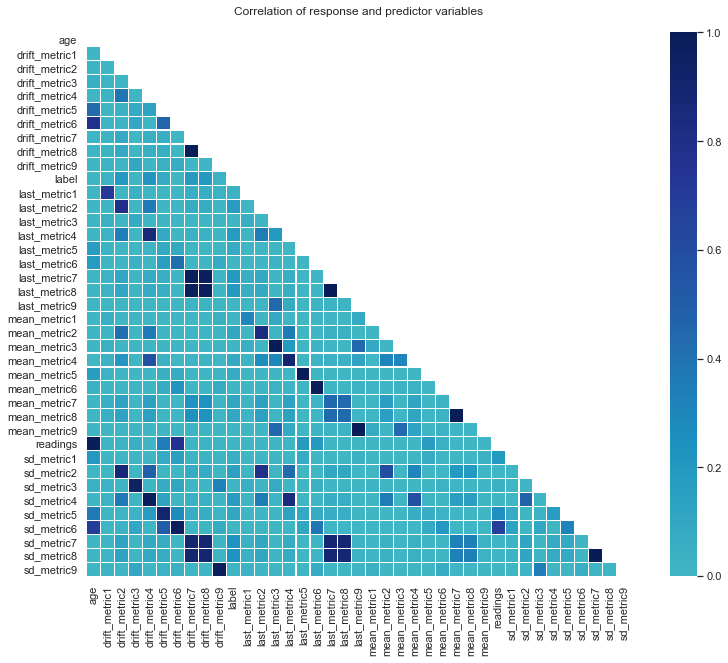

In [85]:
correlation_mask = np.zeros_like(correlation_df.values)
correlation_mask[np.triu_indices_from(correlation_mask)] = True

sns.set(font_scale=1, style='whitegrid')
fig, ax = plt.subplots(figsize=(14,10))
ax.set_title('Correlation of response and predictor variables\n')
sns.heatmap(correlation_df, mask=correlation_mask, center=0, vmin=0, vmax=1, linewidths=.1, cmap='YlGnBu', square=True, ax=ax);

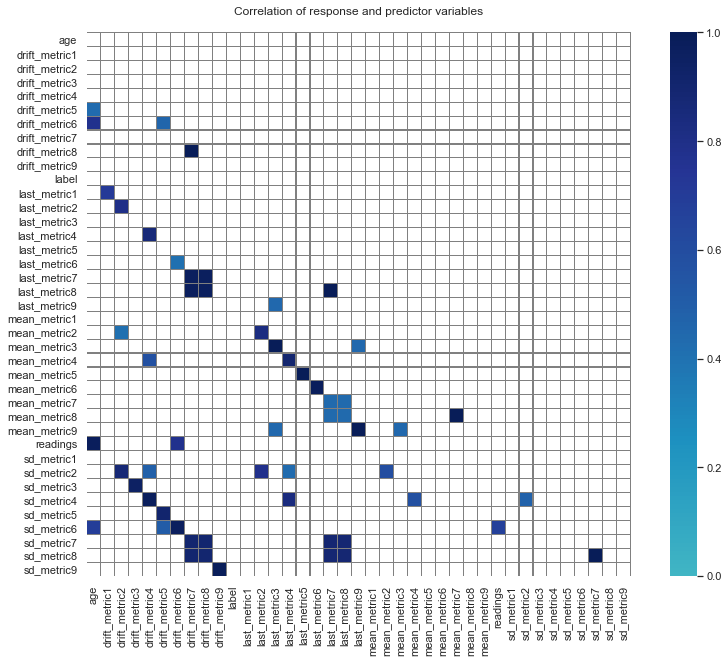

In [86]:
correlation_mask = np.zeros_like(correlation_df.values)
correlation_mask[correlation_df.values < 0.4] = True
correlation_mask[np.triu_indices_from(correlation_mask)] = True

sns.set(font_scale=1, style='whitegrid')
fig, ax = plt.subplots(figsize=(14,10))
ax.set_title('Correlation of response and predictor variables\n')
sns.heatmap(correlation_df, mask=correlation_mask, center=0, vmin=0, vmax=1, linewidths=.1, linecolor='gray', cmap='YlGnBu', square=True, ax=ax);

## Stratified Train / Test Split

In [87]:
train_pct = 0.8
test_pct = 1 - train_pct

telemetry_0 = spark.sql(
'''
SELECT
    *
FROM telemetry
WHERE label = 0
''')
telemetry_0_train, telemetry_0_test = telemetry_0.randomSplit([train_pct, test_pct])

telemetry_1 = spark.sql(
'''
SELECT
    *
FROM telemetry
WHERE label = 1
''')
telemetry_1_train, telemetry_1_test = telemetry_1.randomSplit([train_pct, test_pct])

train_sdf = telemetry_0_train.union(telemetry_1_train)
test_sdf = telemetry_0_test.union(telemetry_1_test)

In [88]:
train_sdf.groupBy('label').count().toPandas()

,label,count
0,1,84
1,0,99404


In [89]:
test_sdf.groupBy('label').count().toPandas()

,label,count
0,1,22
1,0,24984


## Machine Learning Pipeline

In [98]:
feature_cols = sorted(list(set(transformed_cols) - {'id','min_date','max_date','label','readings'} - set([col for col in transformed_cols if 'metric8' in col])))
feature_assembler = VectorAssembler(
    inputCols=feature_cols,
    outputCol='features'
)

In [100]:
rf = RandomForestClassifier(
    featuresCol='features', 
    labelCol='label', 
    predictionCol='prediction', 
    probabilityCol='probability', 
    rawPredictionCol='raw_prediction',
    numTrees=500
)

rf_pipeline = Pipeline(stages=transformers + [feature_assembler, rf])

In [101]:
rf_model = rf_pipeline.fit(train_sdf)

# rf predictions on test data.
rf_predict_test_sdf = rf_model.transform(test_sdf)
rf_predict_test_sdf.createOrReplaceTempView('predictions')
rf_predict_test_sdf.toPandas().head(5)

In [103]:
from pyspark.sql.functions import udf, col
from pyspark.sql.types import ArrayType, DoubleType

def to_array(col):
    def to_array_(v):
        return v.toArray().tolist()
    return udf(to_array_, ArrayType(DoubleType()))(col)

rf_predict_test_sdf = rf_predict_test_sdf \
    .withColumn('probability', to_array(col('probability'))) \
    .select(['*'] + [col('probability')[i] for i in range(2)])
    
rf_predict_test_sdf.createOrReplaceTempView('predictions')

In [104]:
def confusion_summary(thresholds=[0.5], predictions_tbl='predictions'):
    
    confusion_summaries_df = pd.DataFrame(columns=['Threshold','TP','TN','FP','FN','Accuracy','Precision','Recall','F1'])
    for threshold in thresholds:
        confusion_summary_sql = \
        '''
        SELECT
            {threshold} AS Threshold,
            TP,
            TN,
            FP,
            FN,
            (TP + TN) / (TP + TN + FP + FN) AS Accuracy,
            TP / (TP + FP) AS Precision,
            TP / (TP + FN) AS Recall,
            2*TP / (2*TP + FP + FN) AS F1
        FROM (
            SELECT
                SUM(CASE WHEN prediction = 1 AND label = 1 THEN 1 ELSE 0 END) AS TP,
                SUM(CASE WHEN prediction = 0 AND label = 0 THEN 1 ELSE 0 END) AS TN,
                SUM(CASE WHEN prediction = 1 AND label = 0 THEN 1 ELSE 0 END) AS FP,
                SUM(CASE WHEN prediction = 0 AND label = 1 THEN 1 ELSE 0 END) AS FN
            FROM (
                SELECT
                    label,
                    CASE WHEN probability[1] > {threshold} THEN 1 ELSE 0 END AS prediction
                FROM {predictions}
            )
        )
        '''.format(**{'threshold':threshold,'predictions':predictions_tbl})
        confusion_summary_df = spark.sql(confusion_summary_sql).toPandas()
        confusion_summaries_df = confusion_summaries_df.append(confusion_summary_df, ignore_index=True)

    return confusion_summaries_df

confusion_summary(thresholds=[0.1,0.2,0.3,0.4,0.5])

,Threshold,TP,TN,FP,FN,Accuracy,Precision,Recall,F1
0,0.1,19,772,116,3,0.869231,0.140741,0.863636,0.242038
1,0.2,18,814,74,4,0.914286,0.195652,0.818182,0.315789
2,0.3,12,839,49,10,0.935165,0.196721,0.545455,0.289157
3,0.4,8,856,32,14,0.949451,0.200000,0.363636,0.258065
4,0.5,2,870,18,20,0.958242,0.100000,0.090909,0.095238


In [97]:
evaluator = BinaryClassificationEvaluator(metricName='areaUnderROC', rawPredictionCol='raw_prediction', labelCol='label')
area_under_roc = evaluator.evaluate(rf_predict_test_sdf)
print('Area under ROC = %g' % area_under_roc)

evaluator = BinaryClassificationEvaluator(metricName='areaUnderPR', rawPredictionCol='raw_prediction', labelCol='label')
area_under_pr = evaluator.evaluate(rf_predict_test_sdf)
print('Area under PR = %g' % area_under_pr)

Area under ROC = 0.927672
Area under PR = 0.161514


### Class weight transformer

Create a class weight transformer that adds a class_weight column to be used for weighting classes.

In [116]:
weight_sql = \
'''
SELECT telemetry.*, weights.class_weight
FROM telemetry
LEFT JOIN (
    -- Calculate % 0s and 1s and use complement rule to calculate class weights.
    SELECT *, (1.0 - (count / SUM(count) OVER ())) AS class_weight
    FROM (
        -- Count 0s and 1s.
        SELECT
            label, COUNT(label) AS count
        FROM telemetry
        GROUP BY label
    )
) AS weights
ON telemetry.label = weights.label
'''

weight_transformer = SQLTransformer(statement=weight_sql.replace('telemetry','__THIS__'))

In [117]:
transformers = [
    summary_transformer,
    weight_transformer
]

transformed_sdf = Pipeline(stages=transformers).fit(telemetry_sdf).transform(telemetry_sdf)
transformed_sdf.createOrReplaceTempView('transformed')
transformed_cols = transformed_sdf.columns

## Machine Learning Pipeline

In [118]:
feature_cols = sorted(list(set(transformed_cols) - {'id','min_date','max_date','class_weight','label','readings'} - set([col for col in transformed_cols if 'metric8' in col])))
feature_assembler = VectorAssembler(
    inputCols=feature_cols,
    outputCol='features'
)

In [119]:
scaler = StandardScaler(
    inputCol='features', 
    outputCol='scaled_features',
    withStd=True, 
    withMean=True)

In [124]:
lr = LogisticRegression(
    featuresCol='scaled_features', 
    labelCol='label', 
    predictionCol='prediction', 
    maxIter=100, 
    fitIntercept=True, 
    threshold=0.5, 
    probabilityCol='probability', 
    rawPredictionCol='raw_prediction', 
    standardization=False, 
    weightCol='class_weight', 
    family='binomial'
)

lr_pipeline = Pipeline(stages=transformers + [feature_assembler, scaler, lr])

In [125]:
lr_model = lr_pipeline.fit(train_sdf)

# lr predictions on test data.
lr_predict_test_sdf = lr_model.transform(test_sdf)
lr_predict_test_sdf.createOrReplaceTempView('predictions')
lr_predict_test_sdf.toPandas().head(5)

,id,label,min_date,max_date,age,readings,mean_metric1,mean_metric2,mean_metric3,mean_metric4,mean_metric5,mean_metric6,mean_metric7,mean_metric8,mean_metric9,sd_metric1,sd_metric2,sd_metric3,sd_metric4,sd_metric5,sd_metric6,sd_metric7,sd_metric8,sd_metric9,drift_metric1,drift_metric2,drift_metric3,drift_metric4,drift_metric5,drift_metric6,drift_metric7,drift_metric8,drift_metric9,last_metric1,last_metric2,last_metric3,last_metric4,last_metric5,last_metric6,last_metric7,last_metric8,last_metric9,class_weight,features,scaled_features,raw_prediction,probability,prediction
0,S1F09DZQ,1,2015-01-15,2015-07-18,185.0,32.0,1.151920e+08,451.250000,0.0,2.656250,6.9375,407081.750000,0.000000,0.000000,2.0,6.915226e+07,410.358066,0.0,0.482559,0.245935,4257.444039,0.00000,0.00000,0.0,-12224624.0,2160.0,0.0,1.0,1.0,22448.0,0.0,0.0,0.0,77351504.0,2304.0,0.0,3.0,7.0,418563.0,0.0,0.0,2.0,0.975824,"[185.0, -12224624.0, 2160.0, 0.0, 1.0, 1.0, 22...","[0.6998231686777033, -0.1253453875189905, 0.35...","[2.7401382829693977, -2.7401382829693977]","[0.9393539748788976, 0.06064602512110238]",0.0
1,S1F0GG8X,1,2015-01-04,2015-01-18,15.0,3.0,1.098275e+08,43573.333333,0.0,53.333333,11.0000,191914.666667,0.000000,0.000000,2.0,5.803404e+07,36654.813890,0.0,92.376043,0.000000,457.838763,0.00000,0.00000,0.0,-50824880.0,63488.0,0.0,160.0,0.0,793.0,0.0,0.0,0.0,54292264.0,64736.0,0.0,160.0,11.0,192179.0,0.0,0.0,2.0,0.975824,"[15.0, -50824880.0, 63488.0, 0.0, 160.0, 0.0, ...","[-0.9355120881456088, -0.5068485465821928, 13....","[7.083461443689121, -7.083461443689121]","[0.9991618386686275, 0.000838161331372509]",0.0
2,S1F0GKFX,1,2015-01-01,2015-04-27,117.0,31.0,1.383917e+08,0.000000,0.0,1.354839,65.0000,241727.741935,0.000000,0.000000,0.0,6.484192e+07,0.000000,0.0,4.301538,0.000000,5080.129296,0.00000,0.00000,0.0,14752320.0,0.0,0.0,18.0,0.0,23549.0,0.0,0.0,0.0,121900592.0,0.0,0.0,18.0,65.0,246719.0,0.0,0.0,0.0,0.975824,"(117.0, 14752320.0, 0.0, 0.0, 18.0, 0.0, 23549...","[0.04568906594837849, 0.14127951149388396, -0....","[-1.1735995869120388, 1.1735995869120388]","[0.23620495843324518, 0.7637950415667548]",1.0
3,S1F0L0DW,1,2015-01-02,2015-05-21,140.0,25.0,1.302226e+08,0.000000,0.0,0.080000,7.0800,307468.560000,0.000000,0.000000,0.0,6.784287e+07,0.000000,0.0,0.400000,0.276887,7010.218072,0.00000,0.00000,0.0,-79701920.0,0.0,0.0,2.0,1.0,32875.0,0.0,0.0,0.0,151755032.0,0.0,0.0,2.0,8.0,316174.0,0.0,0.0,0.0,0.975824,"(140.0, -79701920.0, 0.0, 0.0, 2.0, 1.0, 32875...","[0.26694030657741485, -0.7922529227706422, -0....","[-0.24541017359231354, 0.24541017359231354]","[0.43895353233130235, 0.5610464676686976]",1.0
4,S1F0LCVC,1,2015-01-13,2015-04-28,106.0,26.0,1.232921e+08,101.846154,0.0,0.000000,8.0000,218448.230769,6.769231,6.769231,0.0,7.819549e+07,162.154418,0.0,0.000000,0.000000,1354.008222,34.51644,34.51644,0.0,-13979184.0,520.0,0.0,0.0,0.0,5614.0,176.0,176.0,0.0,222122448.0,520.0,0.0,0.0,8.0,218975.0,176.0,176.0,0.0,0.975824,"(106.0, -13979184.0, 520.0, 0.0, 0.0, 0.0, 561...","[-0.060126744787247596, -0.14268646895549528, ...","[-3.629951533256335, 3.629951533256335]","[0.025832458169134626, 0.9741675418308654]",1.0


In [126]:
lr_predict_test_sdf = lr_predict_test_sdf \
    .withColumn('probability', to_array(col('probability'))) \
    .select(['*'] + [col('probability')[i] for i in range(2)])
    
lr_predict_test_sdf.createOrReplaceTempView('predictions')

confusion_summary(thresholds=[0.1,0.2,0.3,0.4,0.5])

,Threshold,TP,TN,FP,FN,Accuracy,Precision,Recall,F1
0,0.1,19,197,691,3,0.237363,0.026761,0.863636,0.051913
1,0.2,18,342,546,4,0.395604,0.031915,0.818182,0.061433
2,0.3,17,482,406,5,0.548352,0.040189,0.772727,0.076404
3,0.4,17,602,286,5,0.680220,0.056106,0.772727,0.104615
4,0.5,15,711,177,7,0.797802,0.078125,0.681818,0.140187


## We'll use PySpark, Pandas, NumPy, Matplotlib, and Seaborn

In [1]:
from pyspark.sql import SparkSession
from pyspark.ml.stat import Correlation

from pyspark.ml.feature import SQLTransformer
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import OneHotEncoderEstimator
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline
from pyspark.ml.tuning import ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from spark_stratifier import StratifiedCrossValidator

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

## Start a Spark Session

In [2]:
spark = SparkSession.builder \
    .appName('predictive-maintenance') \
    .master('local[8]') \
    .getOrCreate()

## Read and clean data

In [3]:
telemetry_sdf = spark.read.csv('predictive_maintenance.csv', sep=',', header=True)
telemetry_sdf.createOrReplaceTempView('telemetry')
telemetry_sdf.show(5)

+----------+--------+-------+---------+-------+-------+-------+-------+-------+-------+-------+-------+
|      date|      id|failure|  metric1|metric2|metric3|metric4|metric5|metric6|metric7|metric8|metric9|
+----------+--------+-------+---------+-------+-------+-------+-------+-------+-------+-------+-------+
|2015-01-01|S1F01085|      0|215630672|     56|      0|     52|      6| 407438|      0|      0|      7|
|2015-01-01|S1F0166B|      0| 61370680|      0|      3|      0|      6| 403174|      0|      0|      0|
|2015-01-01|S1F01E6Y|      0|173295968|      0|      0|      0|     12| 237394|      0|      0|      0|
|2015-01-01|S1F01JE0|      0| 79694024|      0|      0|      0|      6| 410186|      0|      0|      0|
|2015-01-01|S1F01R2B|      0|135970480|      0|      0|      0|     15| 313173|      0|      0|      3|
+----------+--------+-------+---------+-------+-------+-------+-------+-------+-------+-------+-------+
only showing top 5 rows



In [4]:
telemetry_sdf = spark.sql(
'''
SELECT
    CAST(date AS DATE) AS date,
    id,
    CAST(failure AS INTEGER) AS label,
    CAST(metric1 AS DOUBLE) AS metric1,
    CAST(metric2 AS DOUBLE) AS metric2,
    CAST(metric3 AS DOUBLE) AS metric3,
    CAST(metric4 AS DOUBLE) AS metric4,
    CAST(metric5 AS DOUBLE) AS metric5,
    CAST(metric6 AS DOUBLE) AS metric6,
    CAST(metric7 AS DOUBLE) AS metric7,
    CAST(metric8 AS DOUBLE) AS metric8,
    CAST(metric9 AS DOUBLE) AS metric9
FROM telemetry
''')
telemetry_sdf.createOrReplaceTempView('telemetry')
telemetry_sdf.printSchema()

root
 |-- date: date (nullable = true)
 |-- id: string (nullable = true)
 |-- label: integer (nullable = true)
 |-- metric1: double (nullable = true)
 |-- metric2: double (nullable = true)
 |-- metric3: double (nullable = true)
 |-- metric4: double (nullable = true)
 |-- metric5: double (nullable = true)
 |-- metric6: double (nullable = true)
 |-- metric7: double (nullable = true)
 |-- metric8: double (nullable = true)
 |-- metric9: double (nullable = true)



## Exploratory data analysis

### How many observations do we have?

We have 124,494 data points. We don't need to use Spark, but we may not always be so lucky. So let's build something scalable!

In [5]:
spark.sql(
'''
SELECT
    COUNT(*) AS total
FROM telemetry
''').toPandas()

,total
0,124494


### How imbalanced are we at the observation level?

Very imbalanced! Only ~0.085% of our observations are failures. We could rebalance the data using undersampling, oversampling, or SMOTE. However, I (and most of my clients) prefer to build a better model over engineering new data. So I typically prefer to use **class weighting**. Alternatively, we could see if our data is less imbalanced at the device level.

In [6]:
spark.sql(
'''
SELECT *, (count / SUM(count) OVER ()) AS percent
FROM (
    SELECT
        label, COUNT(label) AS count
    FROM telemetry
    GROUP BY label
)
''').toPandas()

,label,count,percent
0,1,106,0.000851
1,0,124388,0.999149


### How imbalanced are we at the device level?

Less imbalanced indeed! ~9% of our devices fail. We would still need to rebalance the data. However, the class imbalance is much less pronounced at the device level.

In [7]:
spark.sql(
'''
SELECT *, (count / SUM(count) OVER ()) AS percent
FROM (
    SELECT
        label, COUNT(label) AS count
    FROM (
        SELECT
            id, MAX(label) AS label
        FROM telemetry
        GROUP BY id
    )
    GROUP BY label
)
''').toPandas()

,label,count,percent
0,1,106,0.090676
1,0,1063,0.909324


### Should our model be at the observation or device level?

In a first model, at the observation level, we were able to overcome the class imbalance (achieved high recall). However, we had less luck separating the signal from the noise (achieved low precision).

In my experience working with advertising data, the right amount of aggregation can go a long way to separate the signal from the noise.

**So let's try an aggregate model at the device level.**

We'll have fewer data points to work with, but we'll also be using "summary" features. So we should be able to maintain a reasonable sampling density.

### How many unique values in each column and what do they look like?

Metrics 1 and 6 have a large number of unique unequally spaced integer values over large ranges and, therefore, are likely **numeric features**.

Metric 2 has a moderate number of unique equally spaced integer values and, therefore, is likely an **interval feature** (with interval 8). While it could be a categorical or ordinal feature, 558 categories or scales would be a lot. So we've assumed it is an interval feature and, therefore, the difference between two values is assumed to be meaningful. 

Metric 5 has a small number of unique almost equally spaced integer values over the range 1 to 98 and, therefore, is likely an **interval feature** (with interval 1) and may represent temperature in degrees Celsius.

Metrics 3, 4, 7, 8, and 9 have a small number of unique unequally spaced integer values over large ranges and, therefore, are probably **numeric features**.

In [8]:
spark.sql(
'''
SELECT
    COUNT(DISTINCT id) AS id, 
    COUNT(DISTINCT metric1) AS metric1,
    COUNT(DISTINCT metric2) AS metric2,
    COUNT(DISTINCT metric3) AS metric3,
    COUNT(DISTINCT metric4) AS metric4,
    COUNT(DISTINCT metric5) AS metric5,
    COUNT(DISTINCT metric6) AS metric6,
    COUNT(DISTINCT metric7) AS metric7,
    COUNT(DISTINCT metric8) AS metric8,
    COUNT(DISTINCT metric9) AS metric9
FROM telemetry
''').toPandas()

,id,metric1,metric2,metric3,metric4,metric5,metric6,metric7,metric8,metric9
0,1169,123877,558,47,115,60,44838,28,28,65


In [9]:
spark.sql(
'''
SELECT
    DISTINCT metric9 AS metric9
FROM telemetry
ORDER BY metric9
LIMIT 100
''').toPandas(); # Remove semicolon to view.

### How many days old are devices when they fail?

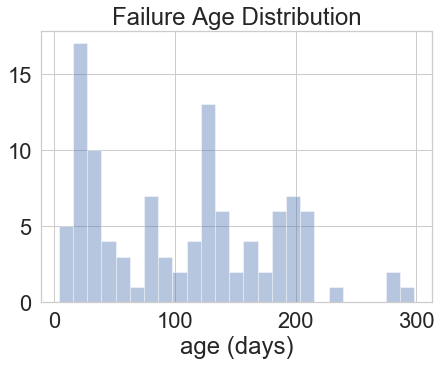

In [10]:
age_sql = \
'''
SELECT telemetry.*, CAST(DATEDIFF(telemetry.date, dates.min_date) AS DOUBLE) AS age
FROM telemetry
LEFT JOIN (
    SELECT id, MIN(date) AS min_date 
    FROM telemetry
    GROUP BY id
) AS dates
ON telemetry.id =  dates.id
'''

failure_age_df = spark.sql('SELECT * FROM (' + age_sql + ') WHERE label = 1').toPandas()

sns.set(font_scale=2, style='whitegrid')
fig, ax = plt.subplots(figsize=(7,5))
sns.distplot(failure_age_df['age'], bins=25, kde=False, ax=ax)
ax.set_title('Failure Age Distribution')
ax.set_xlabel('age (days)');

### What do our min, max, mean, median, and stdev summary statistics tell us?

First, our summary statistics tell us we better **standardize** (center and scale) our features! Our summary statistics vary greatly across our features. We'll need to standardize in order to put our features on the same playing field numerically. We want our model to learn from the patterns in our data and not be skewed by the properties of our data.  Another benefit of standardization, is that it makes our model less sensitive to outliers and, therefore, more robust.

Second, our summary statistics suggest that min, max, mean, and standard deviation may be good "summary" features for our aggregate model since some variation appears to exist between failures and non-failures. 

Third, unfortunately, it appears that median and age may not be very informative features since little variation appears to exist between failures and non-failures.

In [11]:
spark.sql(
'''
SELECT
    label,
    MIN(metric1) AS metric1,
    MIN(metric2) AS metric2,
    MIN(metric3) AS metric3,
    MIN(metric4) AS metric4,
    MIN(metric5) AS metric5,
    MIN(metric6) AS metric6,
    MIN(metric7) AS metric7,
    MIN(metric8) AS metric8,
    MIN(metric9) AS metric9,
    MIN(age) AS age
FROM (''' + age_sql + ''')
GROUP BY label
''').toPandas()

,label,metric1,metric2,metric3,metric4,metric5,metric6,metric7,metric8,metric9,age
0,1,4527376.0,0.0,0.0,0.0,3.0,24.0,0.0,0.0,0.0,4.0
1,0,0.0,0.0,0.0,0.0,1.0,8.0,0.0,0.0,0.0,0.0


In [12]:
spark.sql(
'''
SELECT
    label,
    MAX(metric1) AS metric1,
    MAX(metric2) AS metric2,
    MAX(metric3) AS metric3,
    MAX(metric4) AS metric4,
    MAX(metric5) AS metric5,
    MAX(metric6) AS metric6,
    MAX(metric7) AS metric7,
    MAX(metric8) AS metric8,
    MAX(metric9) AS metric9,
    MAX(age) AS age
FROM (''' + age_sql + ''')
GROUP BY label
''').toPandas()

,label,metric1,metric2,metric3,metric4,metric5,metric6,metric7,metric8,metric9,age
0,1,243261216.0,64784.0,318.0,1666.0,91.0,574599.0,832.0,832.0,1165.0,298.0
1,0,244140480.0,64968.0,24929.0,1666.0,98.0,689161.0,832.0,832.0,18701.0,305.0


In [13]:
spark.sql(
'''
SELECT
    label,
    AVG(metric1) AS metric1,
    AVG(metric2) AS metric2,
    AVG(metric3) AS metric3,
    AVG(metric4) AS metric4,
    AVG(metric5) AS metric5,
    AVG(metric6) AS metric6,
    AVG(metric7) AS metric7,
    AVG(metric8) AS metric8,
    AVG(metric9) AS metric9,
    AVG(age) AS age
FROM (''' + age_sql + ''')
GROUP BY label
''').toPandas()

,label,metric1,metric2,metric3,metric4,metric5,metric6,metric7,metric8,metric9,age
0,1,1.271755e+08,4109.433962,3.905660,54.632075,15.462264,258303.481132,30.622642,30.622642,23.084906,106.905660
1,0,1.223840e+08,156.118725,9.945598,1.696048,14.221613,260174.250587,0.266682,0.266682,12.442462,105.142216


In [14]:
spark.sql(
'''
SELECT
    label,
    PERCENTILE(metric1, 0.5) AS metric1,
    PERCENTILE(metric2, 0.5) AS metric2,
    PERCENTILE(metric3, 0.5) AS metric3,
    PERCENTILE(metric4, 0.5) AS metric4,
    PERCENTILE(metric5, 0.5) AS metric5,
    PERCENTILE(metric6, 0.5) AS metric6,
    PERCENTILE(metric7, 0.5) AS metric7,
    PERCENTILE(metric8, 0.5) AS metric8,
    PERCENTILE(metric9, 0.5) AS metric9,
    PERCENTILE(age, 0.5) AS age
FROM (''' + age_sql + ''')
GROUP BY label
''').toPandas()

,label,metric1,metric2,metric3,metric4,metric5,metric6,metric7,metric8,metric9,age
0,1,139117253.5,0.0,0.0,1.5,10.0,267648.5,0.0,0.0,0.0,113.0
1,0,122786072.0,0.0,0.0,0.0,10.0,249794.0,0.0,0.0,0.0,85.0


In [15]:
spark.sql(
'''
SELECT
    label,
    STDDEV_SAMP(metric1) AS metric1,
    STDDEV_SAMP(metric2) AS metric2,
    STDDEV_SAMP(metric3) AS metric3,
    STDDEV_SAMP(metric4) AS metric4,
    STDDEV_SAMP(metric5) AS metric5,
    STDDEV_SAMP(metric6) AS metric6,
    STDDEV_SAMP(metric7) AS metric7,
    STDDEV_SAMP(metric8) AS metric8,
    STDDEV_SAMP(metric9) AS metric9,
    STDDEV_SAMP(age) AS age
FROM (''' + age_sql + ''')
GROUP BY label
''').toPandas()

,label,metric1,metric2,metric3,metric4,metric5,metric6,metric7,metric8,metric9,age
0,1,6.940167e+07,12803.747239,31.557213,193.492528,15.547270,103349.308593,117.033610,117.033610,153.449984,74.017826
1,0,7.046036e+07,2145.521965,185.824103,22.164316,15.943381,99147.843106,6.558071,6.558071,191.455015,78.403974


### How many null values in each column?

Today must be our lucky day! No nulls = no imputation required.

In [16]:
spark.sql(
'''
SELECT
    SUM(CASE WHEN id IS NULL THEN 1 ELSE 0 END) AS id,
    SUM(CASE WHEN metric1 IS NULL THEN 1 ELSE 0 END) AS metric1,
    SUM(CASE WHEN metric2 IS NULL THEN 1 ELSE 0 END) AS metric2,
    SUM(CASE WHEN metric3 IS NULL THEN 1 ELSE 0 END) AS metric3,
    SUM(CASE WHEN metric4 IS NULL THEN 1 ELSE 0 END) AS metric4,
    SUM(CASE WHEN metric5 IS NULL THEN 1 ELSE 0 END) AS metric5,
    SUM(CASE WHEN metric6 IS NULL THEN 1 ELSE 0 END) AS metric6,
    SUM(CASE WHEN metric7 IS NULL THEN 1 ELSE 0 END) AS metric7,
    SUM(CASE WHEN metric8 IS NULL THEN 1 ELSE 0 END) AS metric8,
    SUM(CASE WHEN metric9 IS NULL THEN 1 ELSE 0 END) AS metric9
FROM telemetry
''').toPandas()

,id,metric1,metric2,metric3,metric4,metric5,metric6,metric7,metric8,metric9
0,0,0,0,0,0,0,0,0,0,0


## Transformations / feature engineering

As we noted earlier, we have a very imbalanced dataset. Rather than undersampling, oversampling, or using SMOTE, we chose class weighting. In order to do this, we'll need to develop a class weight transformer.

Then we'll create 3 feature transformers: (1) age, (2) device class, and (3) summary. 

### Summary feature transformer

Create a summary feature transformer.

In [95]:
summary_sql = \
'''
SELECT
    summary.*,
    -- Difference between first and last values for each device.
    (t2.metric1 - t1.metric1) AS delta_metric1,
    (t2.metric2 - t1.metric2) AS delta_metric2,
    (t2.metric3 - t1.metric3) AS delta_metric3,
    (t2.metric4 - t1.metric4) AS delta_metric4,
    (t2.metric5 - t1.metric5) AS delta_metric5,
    (t2.metric6 - t1.metric6) AS delta_metric6,
    (t2.metric7 - t1.metric7) AS delta_metric7,
    (t2.metric8 - t1.metric8) AS delta_metric8,
    (t2.metric9 - t1.metric9) AS delta_metric9
FROM (
    SELECT
        id,
        -- Label indicating device failure.
        MAX(label) AS label,
        -- Min and max date for each device.
        MIN(date) AS min_date,
        MAX(date) AS max_date,
        -- Age of each device.
        CAST(DATEDIFF(MAX(date), MIN(date)) AS DOUBLE) AS age,
        -- Minimum values for each device.
        MIN(metric1) AS min_metric1,
        MIN(metric2) AS min_metric2,
        MIN(metric3) AS min_metric3,
        MIN(metric4) AS min_metric4,
        MIN(metric5) AS min_metric5,
        MIN(metric6) AS min_metric6,
        MIN(metric7) AS min_metric7,
        MIN(metric8) AS min_metric8,
        MIN(metric9) AS min_metric9,
        -- Maximum values for each device.
        MAX(metric1) AS max_metric1,
        MAX(metric2) AS max_metric2,
        MAX(metric3) AS max_metric3,
        MAX(metric4) AS max_metric4,
        MAX(metric5) AS max_metric5,
        MAX(metric6) AS max_metric6,
        MAX(metric7) AS max_metric7,
        MAX(metric8) AS max_metric8,
        MAX(metric9) AS max_metric9,
        -- Mean values for each device.
        AVG(metric1) AS mean_metric1,
        AVG(metric2) AS mean_metric2,
        AVG(metric3) AS mean_metric3,
        AVG(metric4) AS mean_metric4,
        AVG(metric5) AS mean_metric5,
        AVG(metric6) AS mean_metric6,
        AVG(metric7) AS mean_metric7,
        AVG(metric8) AS mean_metric8,
        AVG(metric9) AS mean_metric9,
        -- Standard deviation values for each device.
        STDDEV_SAMP(metric1) AS sd_metric1,
        STDDEV_SAMP(metric2) AS sd_metric2,
        STDDEV_SAMP(metric3) AS sd_metric3,
        STDDEV_SAMP(metric4) AS sd_metric4,
        STDDEV_SAMP(metric5) AS sd_metric5,
        STDDEV_SAMP(metric6) AS sd_metric6,
        STDDEV_SAMP(metric7) AS sd_metric7,
        STDDEV_SAMP(metric8) AS sd_metric8,
        STDDEV_SAMP(metric9) AS sd_metric9,
        -- Device class indicator for each device.
        CASE WHEN SUBSTRING(id, 1, 1) = 'S' THEN 1 ELSE 0 END AS S,
        CASE WHEN SUBSTRING(id, 1, 1) = 'W' THEN 1 ELSE 0 END AS W,
        CASE WHEN SUBSTRING(id, 1, 1) = 'Z' THEN 1 ELSE 0 END AS Z
    FROM telemetry
    GROUP BY id
) AS summary
LEFT JOIN telemetry AS t1 ON summary.id = t1.id AND summary.min_date = t1.date
LEFT JOIN telemetry AS t2 ON summary.id = t2.id AND summary.max_date = t2.date
WHERE summary.sd_metric1 != 'NaN'
'''
summary_sdf = spark.sql(summary_sql)
summary_sdf.createOrReplaceTempView('summary')
summary_sdf.printSchema()

root
 |-- id: string (nullable = true)
 |-- label: integer (nullable = true)
 |-- min_date: date (nullable = true)
 |-- max_date: date (nullable = true)
 |-- age: double (nullable = true)
 |-- min_metric1: double (nullable = true)
 |-- min_metric2: double (nullable = true)
 |-- min_metric3: double (nullable = true)
 |-- min_metric4: double (nullable = true)
 |-- min_metric5: double (nullable = true)
 |-- min_metric6: double (nullable = true)
 |-- min_metric7: double (nullable = true)
 |-- min_metric8: double (nullable = true)
 |-- min_metric9: double (nullable = true)
 |-- max_metric1: double (nullable = true)
 |-- max_metric2: double (nullable = true)
 |-- max_metric3: double (nullable = true)
 |-- max_metric4: double (nullable = true)
 |-- max_metric5: double (nullable = true)
 |-- max_metric6: double (nullable = true)
 |-- max_metric7: double (nullable = true)
 |-- max_metric8: double (nullable = true)
 |-- max_metric9: double (nullable = true)
 |-- mean_metric1: double (nullable = 

In [96]:
summary_transformer = SQLTransformer(statement=summary_sql.replace('telemetry','__THIS__'))

### Class weight transformer

Create a class weight transformer that adds a class_weight column to be used for weighting classes.

In [97]:
weight_sql = \
'''
SELECT telemetry.*, weights.class_weight
FROM telemetry
LEFT JOIN (
    -- Calculate % 0s and 1s and use complement rule to calculate class weights.
    SELECT *, (1.0 - (count / SUM(count) OVER ())) AS class_weight
    FROM (
        -- Count 0s and 1s.
        SELECT
            label, COUNT(label) AS count
        FROM telemetry
        GROUP BY label
    )
) AS weights
ON telemetry.label = weights.label
'''

weight_transformer = SQLTransformer(statement=weight_sql.replace('telemetry','__THIS__'))

In [98]:
spark.sql(weight_sql.replace('telemetry','summary') + 'WHERE summary.label = 0 LIMIT 5').toPandas()

,id,label,min_date,max_date,age,min_metric1,min_metric2,min_metric3,min_metric4,min_metric5,...,delta_metric1,delta_metric2,delta_metric3,delta_metric4,delta_metric5,delta_metric6,delta_metric7,delta_metric8,delta_metric9,class_weight
0,S1F0S02A,0,2015-01-01,2015-01-13,12.0,49170880.0,0.0,0.0,0.0,7.0,...,94822336.0,0.0,0.0,0.0,0.0,11682.0,0.0,0.0,0.0,0.090753
1,S1F1327G,0,2015-01-01,2015-01-05,4.0,109711784.0,0.0,0.0,0.0,11.0,...,81935888.0,0.0,0.0,0.0,0.0,5341.0,0.0,0.0,0.0,0.090753
2,W1F17RLV,0,2015-01-01,2015-08-20,231.0,755872.0,0.0,0.0,0.0,9.0,...,147050784.0,0.0,0.0,0.0,0.0,46687.0,0.0,0.0,0.0,0.090753
3,W1F1MRP9,0,2015-01-01,2015-10-22,294.0,481056.0,0.0,0.0,0.0,6.0,...,-22294056.0,0.0,0.0,0.0,0.0,117136.0,0.0,0.0,0.0,0.090753
4,S1F0SBLG,0,2015-01-01,2015-01-06,5.0,4246064.0,0.0,0.0,0.0,7.0,...,-114037816.0,0.0,0.0,0.0,0.0,2655.0,0.0,0.0,0.0,0.090753


In [99]:
spark.sql(weight_sql.replace('telemetry','summary') + 'WHERE summary.label = 1 LIMIT 5').toPandas()

,id,label,min_date,max_date,age,min_metric1,min_metric2,min_metric3,min_metric4,min_metric5,...,delta_metric1,delta_metric2,delta_metric3,delta_metric4,delta_metric5,delta_metric6,delta_metric7,delta_metric8,delta_metric9,class_weight
0,W1F0PAXH,1,2015-01-01,2015-07-11,191.0,629776.0,0.0,0.0,0.0,14.0,...,157254784.0,0.0,0.0,16.0,2.0,34415.0,0.0,0.0,0.0,0.909247
1,W1F11ZG9,1,2015-01-01,2015-08-17,228.0,378408.0,0.0,9.0,46.0,2.0,...,-59805752.0,648.0,0.0,487.0,1.0,23440.0,0.0,0.0,0.0,0.909247
2,W1F0M4BZ,1,2015-01-01,2015-06-11,161.0,1715816.0,0.0,0.0,0.0,8.0,...,13598792.0,0.0,0.0,16.0,1.0,40996.0,0.0,0.0,0.0,0.909247
3,W1F13SRV,1,2015-01-01,2015-01-13,12.0,15700216.0,1960.0,0.0,0.0,6.0,...,43335680.0,80.0,0.0,0.0,0.0,14870.0,32.0,32.0,0.0,0.909247
4,W1F0VDH2,1,2015-01-01,2015-02-02,32.0,4012656.0,0.0,0.0,0.0,35.0,...,-1358560.0,960.0,0.0,118.0,1.0,30622.0,216.0,216.0,2.0,0.909247


### Combining transformers

In [103]:
transformers = [
    summary_transformer,
    weight_transformer
]

transformed_sdf = Pipeline(stages=transformers).fit(telemetry_sdf).transform(telemetry_sdf)
transformed_sdf.createOrReplaceTempView('transformed')
transformed_cols = transformed_sdf.columns

## Correlations

As can be seen in the correlation table and plot below, metrics 7 and 8 are highly (perfectly) correlated. So we should only consider one of these feaures in modeling. We'll pick metric 7 and drop metric 8. 

In [104]:
correlation_cols = sorted(list(set(transformed_cols) - {'id','min_date','max_date','class_weight'}))
correlation_assembler = VectorAssembler(inputCols=correlation_cols, outputCol='features')
correlation_features = correlation_assembler.transform(transformed_sdf)
correlation_sdm = Correlation.corr(correlation_features, 'features').head()[0]
correlation_array = correlation_sdm.toArray()
correlation_df = pd.DataFrame(data=correlation_array, index=correlation_cols, columns=correlation_cols)

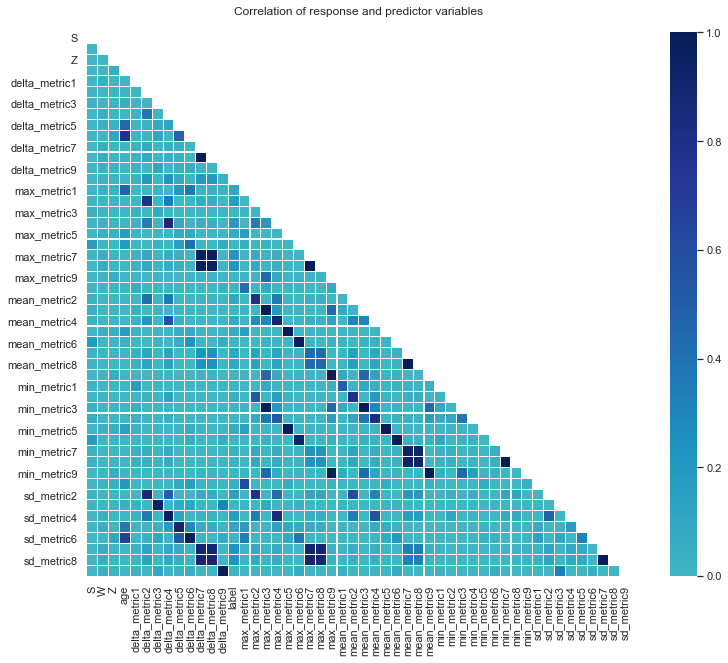

In [105]:
correlation_mask = np.zeros_like(correlation_df.values)
correlation_mask[np.triu_indices_from(correlation_mask)] = True

sns.set(font_scale=1, style='whitegrid')
fig, ax = plt.subplots(figsize=(14,10))
ax.set_title('Correlation of response and predictor variables\n')
sns.heatmap(correlation_df, mask=correlation_mask, center=0, vmin=0, vmax=1, linewidths=.1, cmap='YlGnBu', square=True, ax=ax);

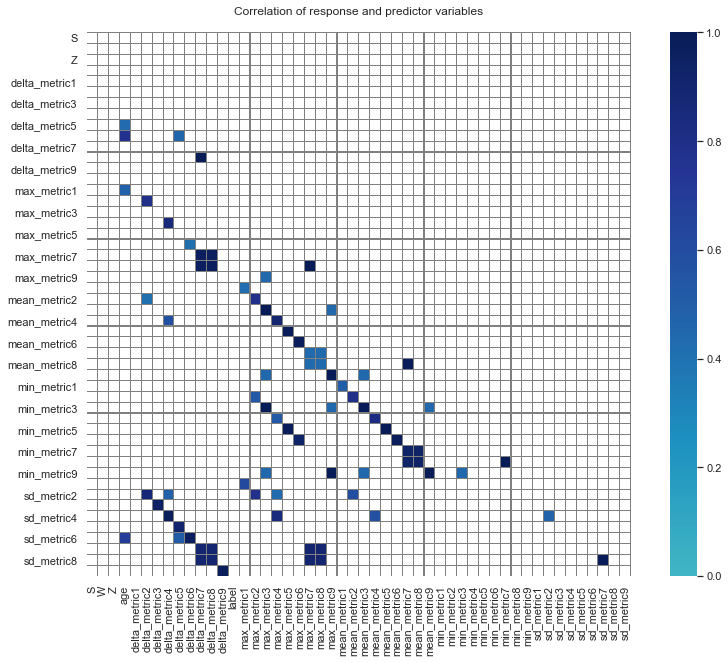

In [106]:
correlation_mask = np.zeros_like(correlation_df.values)
correlation_mask[correlation_df.values < 0.4] = True
correlation_mask[np.triu_indices_from(correlation_mask)] = True

sns.set(font_scale=1, style='whitegrid')
fig, ax = plt.subplots(figsize=(14,10))
ax.set_title('Correlation of response and predictor variables\n')
sns.heatmap(correlation_df, mask=correlation_mask, center=0, vmin=0, vmax=1, linewidths=.1, linecolor='gray', cmap='YlGnBu', square=True, ax=ax);

## Machine Learning Pipeline

In [112]:
feature_cols = sorted(list(set(transformed_cols) - {'id','min_date','max_date','class_weight','label','Z'} - set([col for col in transformed_cols if 'metric8' in col])))
feature_assembler = VectorAssembler(
    inputCols=feature_cols,
    outputCol='features'
)

In [114]:
scaler = StandardScaler(
    inputCol='features', 
    outputCol='scaled_features',
    withStd=True, 
    withMean=True)

In [115]:
lr = LogisticRegression(
    featuresCol='scaled_features', 
    labelCol='label', 
    predictionCol='prediction', 
    maxIter=100, 
    fitIntercept=True, 
    threshold=0.5, 
    probabilityCol='probability', 
    rawPredictionCol='raw_prediction', 
    standardization=False, 
    weightCol='class_weight', 
    family='binomial'
)

pipeline = Pipeline(stages=transformers + [feature_assembler, scaler, lr])

## Train / Test Split

In [117]:
train_pct = 0.8
test_pct = 1 - train_pct

telemetry_0 = spark.sql(
'''
    SELECT
        *
    FROM telemetry
    WHERE label = 0
''')
telemetry_0_train, telemetry_0_test = telemetry_0.randomSplit([train_pct, test_pct])

telemetry_1 = spark.sql(
'''
    SELECT
        *
    FROM telemetry
    WHERE label = 1
''')
telemetry_1_train, telemetry_1_test = telemetry_1.randomSplit([train_pct, test_pct])

train_sdf = telemetry_0_train.union(telemetry_1_train)
test_sdf = telemetry_0_test.union(telemetry_1_test)

In [118]:
train_sdf.groupBy('label').count().show()

+-----+-----+
|label|count|
+-----+-----+
|    1|   83|
|    0|99607|
+-----+-----+



In [119]:
test_sdf.groupBy('label').count().show()

+-----+-----+
|label|count|
+-----+-----+
|    1|   23|
|    0|24781|
+-----+-----+



## Feature Selection using LASSO

In [120]:
# lasso_reg_params = [0.0, 0.001, 0.01, 0.1, 1.0]
lasso_reg_params = [0.01]

lasso_param_grid = ParamGridBuilder() \
    .addGrid(lr.elasticNetParam, [1.0]) \
    .addGrid(lr.regParam, lasso_reg_params) \
    .build()

lasso_cv = StratifiedCrossValidator(
    estimator=pipeline,
    estimatorParamMaps=lasso_param_grid,
    evaluator=BinaryClassificationEvaluator(metricName='areaUnderPR', rawPredictionCol='raw_prediction', labelCol='label'),
    numFolds=5,
    collectSubModels=True
)

In [121]:
# Fit LASSO cross validation model.
lasso_cv_model = lasso_cv.fit(train_sdf)

In [123]:
# Construct LASSO regularization strength vs area under precision-recall curve dataframe.
lasso_avg_metrics = lasso_cv_model.avgMetrics
lasso_avg_metrics_df = pd.DataFrame(columns=['LASSO Regularization','Area Under PR'])
for reg_param, avg_metric in zip(lasso_reg_params, lasso_avg_metrics):
    lasso_avg_metrics_df = lasso_avg_metrics_df.append({'LASSO Regularization':reg_param,'Area Under PR':avg_metric}, ignore_index=True)
lasso_avg_metrics_df

,LASSO Regularization,Area Under PR
0,0.01,0.080345


In [124]:
# Extract nonzero coefficients from best model.
coefficients = lasso_cv_model.bestModel.stages[-1].coefficientMatrix.toArray()[0]
lasso_coefficients_df = pd.DataFrame(columns=['Feature','Coefficient'])
for feature, coefficient in zip(feature_cols, coefficients):
    if np.abs(coefficient) > 0.000001:
        lasso_coefficients_df = lasso_coefficients_df.append({'Feature':feature,'Coefficient':coefficient}, ignore_index=True)
lasso_coefficients_df

,Feature,Coefficient
0,S,-0.051882
1,age,-0.582765
2,delta_metric1,0.030919
3,delta_metric2,0.246958
4,delta_metric4,0.686679
5,delta_metric5,0.021448
6,delta_metric9,0.086219
7,max_metric1,1.178681
8,max_metric2,0.136308
9,max_metric4,0.063605


In [125]:
# Extract intercept from best model.
intercept = lasso_cv_model.bestModel.stages[-1].interceptVector[0]
print('Intercept:',intercept)

Intercept: -0.5922706302859249


In [126]:
# Extract parameters from best model.
param_map = lasso_cv_model.bestModel.stages[-1].extractParamMap()
for param, value in param_map.items():
    print(str(param.name), ' : ', str(value))

aggregationDepth  :  2
elasticNetParam  :  1.0
family  :  binomial
featuresCol  :  scaled_features
fitIntercept  :  True
labelCol  :  label
maxIter  :  100
predictionCol  :  prediction
probabilityCol  :  probability
rawPredictionCol  :  raw_prediction
regParam  :  0.01
standardization  :  False
threshold  :  0.5
tol  :  1e-06
weightCol  :  class_weight


In [129]:
# LASSO predictions on test data.
lasso_predict_test_sdf = lasso_cv_model.transform(test_sdf)
lasso_predict_test_df = lasso_predict_test_sdf.toPandas()
lasso_predict_test_df.head();

lasso_probability = []
for index, value in lasso_predict_test_df['probability'].iteritems():
    lasso_probability.append(value[1])
lasso_probability = np.array(lasso_probability)

In [137]:
true_labels = lasso_predict_test_df['label'].values
pred_labels = np.zeros_like(lasso_probability)
pred_labels[lasso_probability > 0.4] = True

# True Positive (TP) Predict a label of 1 and the true label is 1.
TP = np.sum(np.logical_and(pred_labels == 1, true_labels == 1))
 
# True Negative (TN): Predict a label of 0 and the true label is 0.
TN = np.sum(np.logical_and(pred_labels == 0, true_labels == 0))
 
# False Positive (FP): Predict a label of 1 and the true label is 0.
FP = np.sum(np.logical_and(pred_labels == 1, true_labels == 0))
 
# False Negative (FN): Predict a label of 0 and the true label is 1.
FN = np.sum(np.logical_and(pred_labels == 0, true_labels == 1))

TP = 64
TN = 1036
FP = 26
FN = 42

# How often are we right when we predict failure?
precision = TP / (TP + FP)

# How often do we catch failures?
recall = TP / (TP + FN)
 
print('TP: %i, FP: %i, TN: %i, FN: %i' % (TP,FP,TN,FN))
print('Precision: %f, Recall: %f' % (precision,recall))

TP: 15, FP: 247, TN: 648, FN: 8
Precision: 0.057252, Recall: 0.652174


In [139]:
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(
    featuresCol='features', 
    labelCol='label', 
    predictionCol='prediction', 
    probabilityCol='probability', 
    rawPredictionCol='raw_prediction'
)

pipeline_rf = Pipeline(stages=transformers + [feature_assembler, rf])

In [142]:
rf_model = pipeline_rf.fit(train_sdf)

In [143]:
# rf predictions on test data.
rf_predict_test_sdf = rf_model.transform(test_sdf)
rf_predict_test_df = rf_predict_test_sdf.toPandas()
rf_predict_test_df.head();

rf_probability = []
for index, value in rf_predict_test_df['probability'].iteritems():
    rf_probability.append(value[1])
rf_probability = np.array(rf_probability)

In [8]:
# true_labels = rf_predict_test_df['label'].values
# pred_labels = np.zeros_like(rf_probability)
# pred_labels[rf_probability > 0.5] = True

# # True Positive (TP) Predict a label of 1 and the true label is 1.
# TP = np.sum(np.logical_and(pred_labels == 1, true_labels == 1))
 
# # True Negative (TN): Predict a label of 0 and the true label is 0.
# TN = np.sum(np.logical_and(pred_labels == 0, true_labels == 0))
 
# # False Positive (FP): Predict a label of 1 and the true label is 0.
# FP = np.sum(np.logical_and(pred_labels == 1, true_labels == 0))
 
# # False Negative (FN): Predict a label of 0 and the true label is 1.
# FN = np.sum(np.logical_and(pred_labels == 0, true_labels == 1))

TP = 64
TN = 1036
FP = 26
FN = 42

# TP = 54
# TN = 1054
# FP = 17
# FN = 52

# How often are we right when we predict failure?
precision = TP / (TP + FP)

# How often do we catch failures?
recall = TP / (TP + FN)
 
print('TP: %i, FP: %i, TN: %i, FN: %i' % (TP,FP,TN,FN))
print('Precision: %f, Recall: %f' % (precision,recall))

TP: 64, FP: 26, TN: 1036, FN: 42
Precision: 0.711111, Recall: 0.603774


In [ ]:
TP: 54, FP: 17, TN: 1054, FN: 52
Precision: 0.760563, Recall: 0.509434

In [127]:
# prediction_df = prediction_sdf.select(['label','prediction','probability','raw_prediction']).toPandas()
# prediction_df.loc[prediction_df['label'] == 1]

## 

In [122]:
# Take final features as those 
final_feature_cols = sorted(list(set(lasso_coefficients_df['Feature'].values) - {'ln_metric8','recip_metric8','neg_exp_metric2','recip_metric4','sqrt_metric3'}))

feature_assembler = VectorAssembler(
    inputCols=final_feature_cols,
    outputCol='features'
)

pipeline = Pipeline(stages=transformers + [feature_assembler, scaler, lr])

In [124]:
ridge_reg_params = [0.0, 0.001, 0.01, 0.1, 1.0]

ridge_param_grid = ParamGridBuilder() \
    .addGrid(lr.elasticNetParam, [0.0]) \
    .addGrid(lr.regParam, ridge_reg_params) \
    .build()

ridge_cv = StratifiedCrossValidator(
    estimator=pipeline,
    estimatorParamMaps=ridge_param_grid,
    evaluator=BinaryClassificationEvaluator(metricName='areaUnderPR', rawPredictionCol='raw_prediction', labelCol='label'),
    numFolds=5,
    collectSubModels=True
)

In [125]:
ridge_cv_model = ridge_cv.fit(train_sdf)

In [127]:
# Construct ridge regularization strength vs area under precision-recall curve dataframe.
ridge_avg_metrics = ridge_cv_model.avgMetrics
ridge_avg_metrics_df = pd.DataFrame(columns=['Ridge Regularization','Area Under PR'])
for reg_param, avg_metric in zip(ridge_reg_params, ridge_avg_metrics):
    ridge_avg_metrics_df = ridge_avg_metrics_df.append({'Ridge Regularization':reg_param,'Area Under PR':avg_metric}, ignore_index=True)
ridge_avg_metrics_df

,Ridge Regularization,Area Under PR
0,0.000,0.065898
1,0.001,0.072038
2,0.010,0.064118
3,0.100,0.075409
4,1.000,0.060681
5,10.000,0.059950


In [128]:
# Extract nonzero coefficients from best model.
ridge_coefficients = ridge_cv_model.bestModel.stages[-1].coefficientMatrix.toArray()[0]
ridge_coefficients_df = pd.DataFrame(columns=['Feature','Coefficient'])
for feature, coefficient in zip(final_feature_cols, coefficients):
    ridge_coefficients_df = ridge_coefficients_df.append({'Feature':feature,'Coefficient':coefficient}, ignore_index=True)
ridge_coefficients_df

,Feature,Coefficient
0,W,0.000000
1,ln_age,-0.068500
2,ln_metric2,0.000000
3,ln_metric7,0.308908
4,metric5,0.000000
5,neg_exp_metric3,0.242689
6,neg_exp_metric4,0.000000
7,recip_age,0.000000
8,recip_metric2,0.000000
9,recip_metric5,0.000000


In [129]:
# Extract intercept from best model.
intercept = ridge_cv_model.bestModel.stages[-1].interceptVector[0]
print('Intercept:',intercept)

Intercept: -1.1086506498013124


In [130]:
# Extract parameters from best model.
param_map = ridge_cv_model.bestModel.stages[-1].extractParamMap()
for param, value in param_map.items():
    print(str(param.name), ' : ', str(value))

aggregationDepth  :  2
elasticNetParam  :  0.0
family  :  binomial
featuresCol  :  scaled_features
fitIntercept  :  True
labelCol  :  label
maxIter  :  100
predictionCol  :  prediction
probabilityCol  :  probability
rawPredictionCol  :  raw_prediction
regParam  :  0.1
standardization  :  False
threshold  :  0.5
tol  :  1e-06
weightCol  :  class_weight


In [132]:
# Ridge predictions on test data.
ridge_predict_test_sdf = ridge_cv_model.transform(test_sdf)
ridge_predict_test_df = ridge_predict_test_sdf.toPandas()
ridge_predict_test_df.head()

,date,id,label,metric1,metric2,metric3,metric4,metric5,metric6,metric7,...,recip_metric6,recip_metric7,recip_metric8,recip_metric9,recip_age,features,scaled_features,raw_prediction,probability,prediction
0,2015-01-07,S1F0S02A,0,144510288.0,0.0,0.0,0.0,7.0,248080.0,0.0,...,0.000004,1.0,1.0,1.0,1.000000,"(0.0, 0.0, 0.0, 0.0, 7.0, 1.0, 1.0, 1.0, 1.0, ...","[-0.7299095016264683, -3.595241835837795, -0.2...","[3.2494876386835045, -3.2494876386835045]","[0.9626546973089068, 0.03734530269109318]",0.0
1,2015-01-08,S1F0S02A,0,160461512.0,0.0,0.0,0.0,7.0,249440.0,0.0,...,0.000004,1.0,1.0,1.0,0.500000,"[0.0, 0.6931471805599453, 0.0, 0.0, 7.0, 1.0, ...","[-0.7299095016264683, -3.004043584103168, -0.2...","[2.5342649632251106, -2.5342649632251106]","[0.9265092827987651, 0.07349071720123487]",0.0
2,2015-01-09,S1F0S02A,0,175792840.0,0.0,0.0,0.0,7.0,250851.0,0.0,...,0.000004,1.0,1.0,1.0,0.333333,"[0.0, 1.0986122886681098, 0.0, 0.0, 7.0, 1.0, ...","[-0.7299095016264683, -2.6582147763465045, -0....","[2.2667470166451995, -2.2667470166451995]","[0.9060853415607745, 0.0939146584392256]",0.0
3,2015-01-13,S1F0S02A,0,143993216.0,0.0,0.0,0.0,7.0,256247.0,0.0,...,0.000004,1.0,1.0,1.0,0.142857,"[0.0, 1.9459101490553132, 0.0, 0.0, 7.0, 1.0, ...","[-0.7299095016264683, -1.9355385139187384, -0....","[1.8969370111283639, -1.8969370111283639]","[0.8695444628207186, 0.13045553717928135]",0.0
4,2015-01-03,W1F0PAXH,0,93242264.0,0.0,0.0,0.0,14.0,304951.0,0.0,...,0.000003,1.0,1.0,1.0,1.000000,"[1.0, 0.0, 0.0, 0.0, 14.0, 1.0, 1.0, 1.0, 1.0,...","[1.370019078455745, -3.595241835837795, -0.219...","[3.209796053691896, -3.209796053691896]","[0.9612012604044149, 0.03879873959558507]",0.0


In [198]:
ridge_predict_test_df = ridge_predict_test_sdf.toPandas()

probability = []
for index, value in ridge_predict_test_df['probability'].iteritems():
    probability.append(value[1])
probability = np.array(probability)

In [200]:
probability

array([0.0373453 , 0.07349072, 0.09391466, ..., 0.24331765, 0.18312314,
       0.37458682])

In [209]:
true_labels = ridge_predict_test_df['label'].values
pred_labels = np.zeros_like(probability)
pred_labels[probability > 0.9] = True

# True Positive (TP) Predict a label of 1 and the true label is 1.
TP = np.sum(np.logical_and(pred_labels == 1, true_labels == 1))
 
# True Negative (TN): Predict a label of 0 and the true label is 0.
TN = np.sum(np.logical_and(pred_labels == 0, true_labels == 0))
 
# False Positive (FP): Predict a label of 1 and the true label is 0.
FP = np.sum(np.logical_and(pred_labels == 1, true_labels == 0))
 
# False Negative (FN): Predict a label of 0 and the true label is 1.
FN = np.sum(np.logical_and(pred_labels == 0, true_labels == 1))

TP = 64
TN = 1036
FP = 26
FN = 42

# How often are we right when we predict failure?
precision = TP / (TP + FP)

# How often do we catch failures?
recall = TP / (TP + FN)
 
print('TP: %i, FP: %i, TN: %i, FN: %i' % (TP,FP,TN,FN))
print('Precision: %f, Recall: %f' % (precision,recall))

TP: 64, FP: 26, TN: 1036, FN: 42
Precision: 0.711111, Recall: 0.603774


In [131]:
TP: 18, FP: 2310, TN: 22729, FN: 6
Precision: 0.007732, Recall: 0.750000

NameError: name 'predictions' is not defined

In [64]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

evaluator = BinaryClassificationEvaluator(metricName='areaUnderROC', rawPredictionCol='rawPrediction', labelCol='label')
area_under_roc = evaluator.evaluate(prediction_sdf)
print('Area under ROC = %g' % area_under_roc)

evaluator = BinaryClassificationEvaluator(metricName='areaUnderPR', rawPredictionCol='rawPrediction', labelCol='label')
area_under_pr = evaluator.evaluate(prediction_sdf)
print('Area under PR = %g' % area_under_pr)

Area under ROC = 0.821433
Area under PR = 0.075106


In [88]:
pipeline.fit(telemetry_sdf).transform(telemetry_sdf)

DataFrame[date: date, id: string, failure: int, metric1: double, metric2: double, metric3: double, metric4: double, metric5: double, metric6: double, metric7: double, metric8: double, metric9: double, class_weight: double, age: double, device_class: string, device_index: double, device_encoded: vector, ln_metric1: double, ln_metric2: double, ln_metric3: double, ln_metric4: double, ln_metric5: double, ln_metric6: double, ln_metric7: double, ln_metric8: double, ln_metric9: double, ln_age: double, neg_exp_metric1: double, neg_exp_metric2: double, neg_exp_metric3: double, neg_exp_metric4: double, neg_exp_metric5: double, neg_exp_metric6: double, neg_exp_metric7: double, neg_exp_metric8: double, neg_exp_metric9: double, neg_exp_age: double, sqrt_metric1: double, sqrt_metric2: double, sqrt_metric3: double, sqrt_metric4: double, sqrt_metric5: double, sqrt_metric6: double, sqrt_metric7: double, sqrt_metric8: double, sqrt_metric9: double, sqrt_age: double, recip_metric1: double, recip_metric2: 

In [104]:
model = pipeline.fit(telemetry_train)

In [95]:
prediction = model.transform(telemetry_test)

In [97]:
prediction.toPandas()

,date,id,failure,metric1,metric2,metric3,metric4,metric5,metric6,metric7,metric8,metric9,class_weight,features,scaled_features,rawPrediction,probability,prediction
0,2015-01-01,S1F02MGA,0,44399688.0,0.0,266.0,1.0,6.0,399286.0,0.0,0.0,2269.0,0.000644,"[44399688.0, 0.0, 266.0, 1.0, 6.0, 399286.0, 0...","[-1.1062915066463255, -0.0736061328263951, 1.2...","[-0.8349213833147295, 0.8349213833147295]","[0.3026054762504266, 0.6973945237495733]",1.0
1,2015-01-01,S1F0318A,0,35018688.0,0.0,0.0,0.0,9.0,394890.0,0.0,0.0,5.0,0.000644,"(35018688.0, 0.0, 0.0, 0.0, 9.0, 394890.0, 0.0...","[-1.239511726486609, -0.0736061328263951, -0.0...","[0.7817097048090117, -0.7817097048090117]","[0.6860484774390417, 0.31395152256095826]",0.0
2,2015-01-01,S1F0330P,0,125539768.0,0.0,0.0,12.0,14.0,297284.0,0.0,0.0,5.0,0.000644,"[125539768.0, 0.0, 0.0, 12.0, 14.0, 297284.0, ...","[0.04598429502281244, -0.0736061328263951, -0....","[0.33346672091688623, -0.33346672091688623]","[0.5826026435858288, 0.41739735641417114]",0.0
3,2015-01-01,S1F04Y6C,0,121664216.0,0.0,0.0,7.0,3.0,388821.0,0.0,0.0,0.0,0.000644,"(121664216.0, 0.0, 0.0, 7.0, 3.0, 388821.0, 0....","[-0.009052682851875764, -0.0736061328263951, -...","[0.5895374982743239, -0.5895374982743239]","[0.6432590192872717, 0.3567409807127283]",0.0
4,2015-01-01,S1F06E04,0,67826320.0,1952.0,0.0,12.0,5.0,375985.0,0.0,0.0,0.0,0.000644,"[67826320.0, 1952.0, 0.0, 12.0, 5.0, 375985.0,...","[-0.7736083102752117, 0.8077415112050246, -0.0...","[-0.099474957143741, 0.099474957143741]","[0.47515174734370663, 0.5248482526562934]",1.0
5,2015-01-01,S1F06R6W,0,107727520.0,0.0,0.0,0.0,2.0,397732.0,0.0,0.0,3.0,0.000644,"(107727520.0, 0.0, 0.0, 0.0, 2.0, 397732.0, 0....","[-0.20696865182823204, -0.0736061328263951, -0...","[0.8158400890922793, -0.8158400890922793]","[0.6933525936861826, 0.3066474063138173]",0.0
6,2015-01-01,S1F09MAK,0,9461552.0,7928.0,0.0,7.0,3.0,306534.0,0.0,0.0,4.0,0.000644,"[9461552.0, 7928.0, 0.0, 7.0, 3.0, 306534.0, 0...","[-1.602450355247724, 3.5059656509241655, -0.05...","[-1.5557137628074276, 1.5557137628074276]","[0.17426255475440627, 0.8257374452455937]",1.0
7,2015-01-01,S1F0CVRM,0,3131464.0,520.0,0.0,3.0,4.0,333128.0,0.0,0.0,0.0,0.000644,"[3131464.0, 520.0, 0.0, 3.0, 4.0, 333128.0, 0....","[-1.692344366010792, 0.16117910021476178, -0.0...","[0.5611870773190387, -0.5611870773190387]","[0.6367271625521596, 0.3632728374478405]",0.0
8,2015-01-01,S1F0EGSH,0,40237712.0,0.0,0.0,0.0,11.0,217110.0,0.0,0.0,0.0,0.000644,"(40237712.0, 0.0, 0.0, 0.0, 11.0, 217110.0, 0....","[-1.1653960112503106, -0.0736061328263951, -0....","[0.7077391988320717, -0.7077391988320717]","[0.669901413083802, 0.330098586916198]",0.0
9,2015-01-01,S1F0FVBE,0,220310848.0,0.0,0.0,0.0,14.0,287997.0,0.0,0.0,0.0,0.000644,"(220310848.0, 0.0, 0.0, 0.0, 14.0, 287997.0, 0...","[1.3918348559545985, -0.0736061328263951, -0.0...","[0.6984751468301336, -0.6984751468301336]","[0.6678496059293755, 0.3321503940706245]",0.0


In [ ]:
selected = prediction.select("id", "text", "probability", "prediction")
for row in selected.collect():
    rid, text, prob, prediction = row
    print("(%d, %s) --> prob=%s, prediction=%f" % (rid, text, str(prob), prediction))

### Natural log feature transformer

In [28]:
ln_sql = \
'''
SELECT
    *,
    -- Natural log transform. Add 1 to avoid LN(0) errors.
    LN(metric1 + 1) AS ln_metric1,
    LN(metric2 + 1) AS ln_metric2,
    LN(metric3 + 1) AS ln_metric3,
    LN(metric4 + 1) AS ln_metric4,
    LN(metric5 + 1) AS ln_metric5,
    LN(metric6 + 1) AS ln_metric6,
    LN(metric7 + 1) AS ln_metric7,
    LN(metric8 + 1) AS ln_metric8,
    LN(metric9 + 1) AS ln_metric9,
    LN(age + 1) AS ln_age
FROM telemetry
'''

ln_transformer = SQLTransformer(statement=ln_sql.replace('telemetry','__THIS__'))

spark.sql(ln_sql.replace('telemetry','(' + age_sql + ')') + 'LIMIT 5').toPandas()

,date,id,label,metric1,metric2,metric3,metric4,metric5,metric6,metric7,...,ln_metric1,ln_metric2,ln_metric3,ln_metric4,ln_metric5,ln_metric6,ln_metric7,ln_metric8,ln_metric9,ln_age
0,2015-01-01,S1F01085,0,215630672.0,56.0,0.0,52.0,6.0,407438.0,0.0,...,19.189078,4.043051,0.000000,3.970292,1.945910,12.917647,0.0,0.0,2.079442,0.0
1,2015-01-01,S1F0166B,0,61370680.0,0.0,3.0,0.0,6.0,403174.0,0.0,...,17.932443,0.000000,1.386294,0.000000,1.945910,12.907126,0.0,0.0,0.000000,0.0
2,2015-01-01,S1F01E6Y,0,173295968.0,0.0,0.0,0.0,12.0,237394.0,0.0,...,18.970511,0.000000,0.000000,0.000000,2.564949,12.377481,0.0,0.0,0.000000,0.0
3,2015-01-01,S1F01JE0,0,79694024.0,0.0,0.0,0.0,6.0,410186.0,0.0,...,18.193705,0.000000,0.000000,0.000000,1.945910,12.924368,0.0,0.0,0.000000,0.0
4,2015-01-01,S1F01R2B,0,135970480.0,0.0,0.0,0.0,15.0,313173.0,0.0,...,18.727948,0.000000,0.000000,0.000000,2.772589,12.654514,0.0,0.0,1.386294,0.0


### Negative exponential feature transformer

In [29]:
neg_exp_sql = \
'''
SELECT
    *,
    -- Negative exponential transform.
    EXP(-metric1) AS neg_exp_metric1,
    EXP(-metric2) AS neg_exp_metric2,
    EXP(-metric3) AS neg_exp_metric3,
    EXP(-metric4) AS neg_exp_metric4,
    EXP(-metric5) AS neg_exp_metric5,
    EXP(-metric6) AS neg_exp_metric6,
    EXP(-metric7) AS neg_exp_metric7,
    EXP(-metric8) AS neg_exp_metric8,
    EXP(-metric9) AS neg_exp_metric9,
    EXP(-age) AS neg_exp_age
FROM telemetry
'''

neg_exp_transformer = SQLTransformer(statement=neg_exp_sql.replace('telemetry','__THIS__'))

spark.sql(neg_exp_sql.replace('telemetry','(' + age_sql + ')') + 'LIMIT 5').toPandas()

,date,id,label,metric1,metric2,metric3,metric4,metric5,metric6,metric7,...,neg_exp_metric1,neg_exp_metric2,neg_exp_metric3,neg_exp_metric4,neg_exp_metric5,neg_exp_metric6,neg_exp_metric7,neg_exp_metric8,neg_exp_metric9,neg_exp_age
0,2015-01-01,S1F01085,0,215630672.0,56.0,0.0,52.0,6.0,407438.0,0.0,...,0.0,4.780893e-25,1.000000,2.610279e-23,2.478752e-03,0.0,1.0,1.0,0.000912,1.0
1,2015-01-01,S1F0166B,0,61370680.0,0.0,3.0,0.0,6.0,403174.0,0.0,...,0.0,1.000000e+00,0.049787,1.000000e+00,2.478752e-03,0.0,1.0,1.0,1.000000,1.0
2,2015-01-01,S1F01E6Y,0,173295968.0,0.0,0.0,0.0,12.0,237394.0,0.0,...,0.0,1.000000e+00,1.000000,1.000000e+00,6.144212e-06,0.0,1.0,1.0,1.000000,1.0
3,2015-01-01,S1F01JE0,0,79694024.0,0.0,0.0,0.0,6.0,410186.0,0.0,...,0.0,1.000000e+00,1.000000,1.000000e+00,2.478752e-03,0.0,1.0,1.0,1.000000,1.0
4,2015-01-01,S1F01R2B,0,135970480.0,0.0,0.0,0.0,15.0,313173.0,0.0,...,0.0,1.000000e+00,1.000000,1.000000e+00,3.059023e-07,0.0,1.0,1.0,0.049787,1.0


### Square root feature transformer

In [34]:
sqrt_sql = \
'''
SELECT
    *,
    -- Square root transform.
    SQRT(metric1) AS sqrt_metric1,
    SQRT(metric2) AS sqrt_metric2,
    SQRT(metric3) AS sqrt_metric3,
    SQRT(metric4) AS sqrt_metric4,
    SQRT(metric5) AS sqrt_metric5,
    SQRT(metric6) AS sqrt_metric6,
    SQRT(metric7) AS sqrt_metric7,
    SQRT(metric8) AS sqrt_metric8,
    SQRT(metric9) AS sqrt_metric9,
    SQRT(age) AS sqrt_age
FROM telemetry
'''

sqrt_transformer = SQLTransformer(statement=sqrt_sql.replace('telemetry','__THIS__'))

spark.sql(sqrt_sql.replace('telemetry','(' + age_sql + ')') + 'LIMIT 5').toPandas()

,date,id,label,metric1,metric2,metric3,metric4,metric5,metric6,metric7,...,sqrt_metric1,sqrt_metric2,sqrt_metric3,sqrt_metric4,sqrt_metric5,sqrt_metric6,sqrt_metric7,sqrt_metric8,sqrt_metric9,sqrt_age
0,2015-01-01,S1F01085,0,215630672.0,56.0,0.0,52.0,6.0,407438.0,0.0,...,14684.368287,7.483315,0.000000,7.211103,2.449490,638.308703,0.0,0.0,2.645751,0.0
1,2015-01-01,S1F0166B,0,61370680.0,0.0,3.0,0.0,6.0,403174.0,0.0,...,7833.944090,0.000000,1.732051,0.000000,2.449490,634.959841,0.0,0.0,0.000000,0.0
2,2015-01-01,S1F01E6Y,0,173295968.0,0.0,0.0,0.0,12.0,237394.0,0.0,...,13164.192645,0.000000,0.000000,0.000000,3.464102,487.230951,0.0,0.0,0.000000,0.0
3,2015-01-01,S1F01JE0,0,79694024.0,0.0,0.0,0.0,6.0,410186.0,0.0,...,8927.150945,0.000000,0.000000,0.000000,2.449490,640.457649,0.0,0.0,0.000000,0.0
4,2015-01-01,S1F01R2B,0,135970480.0,0.0,0.0,0.0,15.0,313173.0,0.0,...,11660.638061,0.000000,0.000000,0.000000,3.872983,559.618620,0.0,0.0,1.732051,0.0


### Reciprocal feature transformer

In [36]:
reciprocal_sql = \
'''
SELECT
    *,
    -- Reciprocal transform. Add 1 to avoid divide by 0 errors.
    POW(metric1 + 1, -1) AS recip_metric1,
    POW(metric2 + 1, -1) AS recip_metric2,
    POW(metric3 + 1, -1) AS recip_metric3,
    POW(metric4 + 1, -1) AS recip_metric4,
    POW(metric5 + 1, -1) AS recip_metric5,
    POW(metric6 + 1, -1) AS recip_metric6,
    POW(metric7 + 1, -1) AS recip_metric7,
    POW(metric8 + 1, -1) AS recip_metric8,
    POW(metric9 + 1, -1) AS recip_metric9,
    POW(age + 1, -1) AS recip_age
FROM telemetry
'''

reciprocal_transformer = SQLTransformer(statement=reciprocal_sql.replace('telemetry','__THIS__'))

spark.sql(reciprocal_sql.replace('telemetry','(' + age_sql + ')') + 'LIMIT 5').toPandas()

,date,id,label,metric1,metric2,metric3,metric4,metric5,metric6,metric7,...,recip_metric1,recip_metric2,recip_metric3,recip_metric4,recip_metric5,recip_metric6,recip_metric7,recip_metric8,recip_metric9,recip_age
0,2015-01-01,S1F01085,0,215630672.0,56.0,0.0,52.0,6.0,407438.0,0.0,...,4.637559e-09,0.017544,1.00,0.018868,0.142857,0.000002,1.0,1.0,0.125,1.0
1,2015-01-01,S1F0166B,0,61370680.0,0.0,3.0,0.0,6.0,403174.0,0.0,...,1.629443e-08,1.000000,0.25,1.000000,0.142857,0.000002,1.0,1.0,1.000,1.0
2,2015-01-01,S1F01E6Y,0,173295968.0,0.0,0.0,0.0,12.0,237394.0,0.0,...,5.770475e-09,1.000000,1.00,1.000000,0.076923,0.000004,1.0,1.0,1.000,1.0
3,2015-01-01,S1F01JE0,0,79694024.0,0.0,0.0,0.0,6.0,410186.0,0.0,...,1.254799e-08,1.000000,1.00,1.000000,0.142857,0.000002,1.0,1.0,1.000,1.0
4,2015-01-01,S1F01R2B,0,135970480.0,0.0,0.0,0.0,15.0,313173.0,0.0,...,7.354537e-09,1.000000,1.00,1.000000,0.062500,0.000003,1.0,1.0,0.250,1.0


### Age feature transformer

Create an age feature transformer that adds an "age" column representing the age (days since first telemetry reading) of a device.

In [21]:
spark.sql(age_sql + 'WHERE telemetry.label = 0 LIMIT 5').toPandas()
spark.sql(age_sql + 'WHERE telemetry.label = 1 LIMIT 5').toPandas()

age_transformer = SQLTransformer(statement=age_sql.replace('telemetry','__THIS__'))

,date,id,label,metric1,metric2,metric3,metric4,metric5,metric6,metric7,metric8,metric9,age
0,2015-01-01,S1F01085,0,215630672.0,56.0,0.0,52.0,6.0,407438.0,0.0,0.0,7.0,0.0
1,2015-01-01,S1F0166B,0,61370680.0,0.0,3.0,0.0,6.0,403174.0,0.0,0.0,0.0,0.0
2,2015-01-01,S1F01E6Y,0,173295968.0,0.0,0.0,0.0,12.0,237394.0,0.0,0.0,0.0,0.0
3,2015-01-01,S1F01JE0,0,79694024.0,0.0,0.0,0.0,6.0,410186.0,0.0,0.0,0.0,0.0
4,2015-01-01,S1F01R2B,0,135970480.0,0.0,0.0,0.0,15.0,313173.0,0.0,0.0,3.0,0.0


### Device class feature transformer

In [24]:
device_class_sql = \
'''
SELECT 
    *,
    CASE WHEN SUBSTRING(id, 1, 1) = 'S' THEN 1 ELSE 0 END AS S,
    CASE WHEN SUBSTRING(id, 1, 1) = 'W' THEN 1 ELSE 0 END AS W,
    CASE WHEN SUBSTRING(id, 1, 1) = 'Z' THEN 1 ELSE 0 END AS Z
FROM telemetry
'''

device_class_transformer = SQLTransformer(statement=device_class_sql.replace('telemetry','__THIS__'))

spark.sql('SELECT SUM(S) AS S, SUM(W) AS W, SUM(Z) AS Z FROM (' + device_class_sql + ') GROUP BY label').toPandas()